In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import scipy.stats
mpl.rcParams['figure.dpi'] = 600

# Part 0: Load Data

## Immune Cell Fractions

CIBERSORT result from [*The Immune Landscape of Cancer*](https://www.sciencedirect.com/science/article/pii/S1074761318301213) downloaded from [NIH PanCanAtlas](https://gdc.cancer.gov/about-data/publications/panimmune) includes are SampleID ([TCGA barcode](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/)), Cancer Type ([TCGA Study Abbreviation](https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations)), and the abundance of 22 imuune cell types.

Note that the abundances in each row sum to 1. In other words, the abundance is the proportion of a cell type in the leukocyte compartment (see [below](#lf)), but not all cells (stroma, tumor, etc.).

In [2]:
data = pd.read_csv("TCGA.Kallisto.fullIDs.cibersort.relative.tsv", sep="\t")
data["SampleID"] = data["SampleID"].apply(lambda x: x.replace('.', '-'))
data

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
0,TCGA-OR-A5JG-01A-11R-A29S-07,ACC,0.000000,0.048529,0.016052,0.046099,0.027037,0.290682,0.0,0.000000,...,0.363861,0.002715,0.026125,0.032788,0.000000,0.010290,0.009607,0.112,0.095797,1.047142
1,TCGA-OR-A5LG-01A-11R-A29S-07,ACC,0.007169,0.011125,0.007982,0.139842,0.000000,0.142742,0.0,0.001614,...,0.448243,0.000000,0.007464,0.126237,0.000000,0.000000,0.000000,0.104,0.103345,1.046163
2,TCGA-OR-A5JD-01A-11R-A29S-07,ACC,0.000023,0.014607,0.000000,0.104888,0.000000,0.174895,0.0,0.017928,...,0.329552,0.000000,0.009330,0.000000,0.190730,0.000000,0.000000,0.068,0.143259,1.039812
3,TCGA-OR-A5LH-01A-11R-A29S-07,ACC,0.047299,0.038180,0.000000,0.198591,0.000000,0.065240,0.0,0.043310,...,0.287939,0.000000,0.000576,0.000000,0.064725,0.000000,0.000000,0.388,0.028763,1.080553
4,TCGA-OR-A5KY-01A-11R-A29S-07,ACC,0.000000,0.024795,0.004418,0.051506,0.000000,0.225892,0.0,0.000000,...,0.486400,0.000000,0.042827,0.000000,0.017418,0.014769,0.000000,0.246,0.055621,1.073474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11368,TCGA-V4-A9EQ-01A-11R-A405-07,UVM,0.000000,0.028939,0.008894,0.000000,0.023294,0.015676,0.0,0.002279,...,0.521353,0.009128,0.000000,0.208036,0.000000,0.000000,0.000000,0.090,0.111538,1.060529
11369,TCGA-V4-A9EV-01A-11R-A405-07,UVM,0.000000,0.013299,0.025069,0.315356,0.000000,0.017361,0.0,0.095233,...,0.163671,0.015558,0.000000,0.061707,0.000000,0.000000,0.000000,0.002,0.347125,0.952021
11370,TCGA-V4-A9EY-01A-11R-A405-07,UVM,0.000000,0.032507,0.076160,0.061400,0.034359,0.000000,0.0,0.007778,...,0.431568,0.004550,0.000000,0.227797,0.000000,0.000000,0.000000,0.086,0.113888,1.041876
11371,TCGA-V4-A9EU-01A-11R-A405-07,UVM,0.000000,0.021228,0.010225,0.067985,0.003434,0.006675,0.0,0.004884,...,0.627631,0.000000,0.000000,0.147489,0.000000,0.000000,0.000000,0.096,0.107852,1.068155


In [3]:
tcga_study_abbr_dict = {
    "LAML": "Acute Myeloid Leukemia",
    "ACC": "Adrenocortical carcinoma",
    "BLCA": "Bladder Urothelial Carcinoma",
    "LGG": "Brain Lower Grade Glioma",
    "BRCA": "Breast invasive carcinoma",
    "CESC": "Cervical squamous cell carcinoma and endocervical adenocarcinoma",
    "CHOL": "Cholangiocarcinoma",
    "LCML": "Chronic Myelogenous Leukemia",
    "COAD": "Colon adenocarcinoma",
    "CNTL": "Controls",
    "ESCA": "Esophageal carcinoma",
    "FPPP": "FFPE Pilot Phase II",
    "GBM": "Glioblastoma multiforme",
    "HNSC": "Head and Neck squamous cell carcinoma",
    "KICH": "Kidney Chromophobe",
    "KIRC": "Kidney renal clear cell carcinoma",
    "KIRP": "Kidney renal papillary cell carcinoma",
    "LIHC": "Liver hepatocellular carcinoma",
    "LUAD": "Lung adenocarcinoma",
    "LUSC": "Lung squamous cell carcinoma",
    "DLBC": "Lymphoid Neoplasm Diffuse Large B-cell Lymphoma",
    "MESO": "Mesothelioma",
    "MISC": "Miscellaneous",
    "OV": "Ovarian serous cystadenocarcinoma",
    "PAAD": "Pancreatic adenocarcinoma",
    "PCPG": "Pheochromocytoma and Paraganglioma",
    "PRAD": "Prostate adenocarcinoma",
    "READ": "Rectum adenocarcinoma",
    "SARC": "Sarcoma",
    "SKCM": "Skin Cutaneous Melanoma",
    "STAD": "Stomach adenocarcinoma",
    "TGCT": "Testicular Germ Cell Tumors",
    "THYM": "Thymoma",
    "THCA": "Thyroid carcinoma",
    "UCS": "Uterine Carcinosarcoma",
    "UCEC": "Uterine Corpus Endometrial Carcinoma",
    "UVM": "Uveal Melanoma"
}

In [4]:
tcga_study_abbr_dict2 = {k: v + ' (' + k + ')' for k, v in tcga_study_abbr_dict.items()}
tcga_study_abbr_dict2

{'LAML': 'Acute Myeloid Leukemia (LAML)',
 'ACC': 'Adrenocortical carcinoma (ACC)',
 'BLCA': 'Bladder Urothelial Carcinoma (BLCA)',
 'LGG': 'Brain Lower Grade Glioma (LGG)',
 'BRCA': 'Breast invasive carcinoma (BRCA)',
 'CESC': 'Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC)',
 'CHOL': 'Cholangiocarcinoma (CHOL)',
 'LCML': 'Chronic Myelogenous Leukemia (LCML)',
 'COAD': 'Colon adenocarcinoma (COAD)',
 'CNTL': 'Controls (CNTL)',
 'ESCA': 'Esophageal carcinoma (ESCA)',
 'FPPP': 'FFPE Pilot Phase II (FPPP)',
 'GBM': 'Glioblastoma multiforme (GBM)',
 'HNSC': 'Head and Neck squamous cell carcinoma (HNSC)',
 'KICH': 'Kidney Chromophobe (KICH)',
 'KIRC': 'Kidney renal clear cell carcinoma (KIRC)',
 'KIRP': 'Kidney renal papillary cell carcinoma (KIRP)',
 'LIHC': 'Liver hepatocellular carcinoma (LIHC)',
 'LUAD': 'Lung adenocarcinoma (LUAD)',
 'LUSC': 'Lung squamous cell carcinoma (LUSC)',
 'DLBC': 'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma (DLBC)',
 'MESO': 'Meso

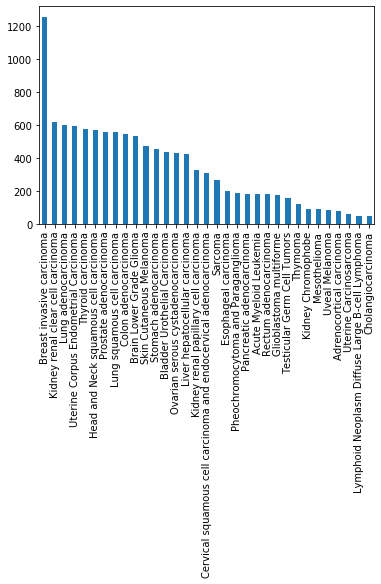

In [5]:
data["CancerType"].apply(tcga_study_abbr_dict.__getitem__).value_counts().plot(kind='bar')

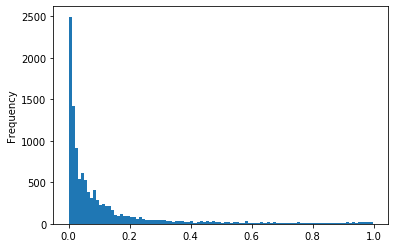

In [6]:
data['P.value'].plot(kind="hist", bins=100)

In [7]:
{'all': data['P.value'].apply(1.00.__ge__).sum(),
'0.05': data['P.value'].apply(0.05.__ge__).sum(),
'0.01': data['P.value'].apply(0.01.__ge__).sum()
}

{'all': 11373, '0.05': 6077, '0.01': 2893}

In [8]:
data['SampleID'].value_counts().where(lambda x: x > 1.0).dropna()

TCGA-A7-A0DC-01B-04R-A22O-07    3.0
TCGA-A7-A26F-01B-04R-A22O-07    3.0
TCGA-A7-A13G-01B-04R-A22O-07    3.0
TCGA-AC-A2QH-01B-04R-A22O-07    3.0
TCGA-AC-A3OD-01B-06R-A22O-07    3.0
TCGA-A7-A0DC-01A-11R-A00Z-07    3.0
TCGA-A7-A26I-01B-06R-A22O-07    3.0
TCGA-AA-A01X-01A-21R-A083-07    2.0
TCGA-AK-3453-01A-02R-1277-07    2.0
TCGA-AZ-4684-01A-01R-1410-07    2.0
TCGA-HC-8258-01B-05R-2302-07    2.0
TCGA-AC-A3OD-01A-11R-A21T-07    2.0
TCGA-AA-A01Z-01A-11R-A083-07    2.0
TCGA-37-4133-01A-01R-1100-07    2.0
TCGA-AA-3509-01A-01R-1410-07    2.0
TCGA-AZ-4313-01A-01R-1410-07    2.0
TCGA-BH-A0B2-01A-11R-A10J-07    2.0
TCGA-AZ-4614-01A-01R-1410-07    2.0
TCGA-AA-3492-01A-01R-1410-07    2.0
TCGA-AX-A1C7-01A-11R-A137-07    2.0
TCGA-AC-A3QQ-01A-11R-A22K-07    2.0
TCGA-A6-2672-01B-03R-2302-07    2.0
TCGA-AZ-4615-01A-01R-1410-07    2.0
TCGA-A2-A0EM-01A-11R-A034-07    2.0
TCGA-FI-A2F8-01A-12R-A17B-07    2.0
TCGA-A7-A26F-01A-21R-A169-07    2.0
TCGA-AA-3502-01A-01R-1410-07    2.0
TCGA-AA-A01P-01A-21R-A083-07

In [9]:
data[data['SampleID'] == 'TCGA-A7-A0DC-01B-04R-A22O-07']

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
1762,TCGA-A7-A0DC-01B-04R-A22O-07,BRCA,0.0,0.095566,0.045122,0.018111,0.130455,0.172505,0.0,0.0,...,0.115555,0.0,0.067555,0.251592,0.0,0.000000,0.0,0.108,0.099062,1.040622
1763,TCGA-A7-A0DC-01B-04R-A22O-07,BRCA,0.0,0.113939,0.040357,0.005743,0.067493,0.214965,0.0,0.0,...,0.125661,0.0,0.058962,0.278053,0.0,0.000000,0.0,0.138,0.078372,1.048953
1764,TCGA-A7-A0DC-01B-04R-A22O-07,BRCA,0.0,0.133703,0.046857,0.018552,0.031506,0.225782,0.0,0.0,...,0.104292,0.0,0.078465,0.211148,0.0,0.001334,0.0,0.244,0.045592,1.056600


## Leukocyte Fractions (LFs)

<a id='lf'></a>
Leukocyte fractions from [The Immune Landscape of Cancer](https://www.sciencedirect.com/science/article/pii/S1074761318301213) downloaded from [NIH PanCanAtlas](https://gdc.cancer.gov/about-data/publications/panimmune).

In [10]:
leuk = pd.read_csv("TCGA_all_leuk_estimate.masked.20170107.tsv", sep="\t", header=None)
leuk.columns = ['CancerType', 'SampleID', 'LF']
leuk

,CancerType,SampleID,LF
0,ACC,TCGA-OR-A5J1-01A-11D-A29J-05,0.046374
1,ACC,TCGA-OR-A5J2-01A-11D-A29J-05,0.057859
2,ACC,TCGA-OR-A5J3-01A-11D-A29J-05,0.048460
3,ACC,TCGA-OR-A5J4-01A-11D-A29J-05,0.043988
4,ACC,TCGA-OR-A5J5-01A-11D-A29J-05,0.016759
...,...,...,...
10812,TGCT,TCGA-ZM-AA0D-01A-11D-A436-05,0.578000
10813,TGCT,TCGA-ZM-AA0E-01A-12D-A436-05,0.512000
10814,TGCT,TCGA-ZM-AA0F-01A-21D-A436-05,0.625000
10815,TGCT,TCGA-ZM-AA0H-01A-11D-A436-05,0.431000


## Merge CIBERSORT and LF

We first investigate the number of samples available.
Remember that the format of TCGA barcode is:


| Label        | Project | TSS | Participant | Sample & Vial | Portion & Analyte | Plate | Center |
|--------------|---------|-----|-------------|---------------|-------------------|-------|--------|
| Subscription | 0       | 1   | 2           | 3             | 4                 | 5     | 6      |
| Example      | TCGA    | OR  | A5J1        | 01A           | 11D               | A29J  | 05     |

If we use Label-Project-TSS-Participant-Sample&Vial as the identifier, there are 10103 matched ones. It goes down to zero if we use up to Portion&Analyte. In fact, the CIBERSORT is based on RNA, while the LF is based on the DNA sample (by methylation analysis).

Finally, we use Label-Project-TSS-Participant-Sample&Vial-Portion, but exclude the Analyter, Plate, and Center as our identifier to match the samples.

Also note that there are "duplicates" in the original tables. For CIBERSORT, we keep the one with lowest p-value. For LF, we take the average.

It is worth noting that "match" here shall not be confused with "matched samples" in "paired test".

In [11]:
id1 = set(data['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:4])))
id2 = set(leuk['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:4])))
{
    '1': len(id1),
    '2': len(id2),
    'intersection': len(id1.intersection(id2))
}

{'1': 11273, '2': 10770, 'intersection': 10103}

In [12]:
id1 = set(data['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:5])))
id2 = set(leuk['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:5])))
{
    '1': len(id1),
    '2': len(id2),
    'intersection': len(id1.intersection(id2))
}

{'1': 11275, '2': 10782, 'intersection': 0}

In [13]:
id1 = set(data['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:4] + [x.split('-')[4][0:2]])))
id2 = set(leuk['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:4] + [x.split('-')[4][0:2]])))
common_id = id1.intersection(id2)
{
    '1': len(id1),
    '2': len(id2),
    'intersection': len(common_id)
}

{'1': 11275, '2': 10782, 'intersection': 10039}

In [14]:
merged = pd.DataFrame()
for id in common_id:
    temp = data[data['SampleID'].apply(lambda x: id in x)]
    temp.loc[:, 'LF'] = leuk.loc[leuk.loc[:, 'SampleID'].apply(lambda x: id in x), 'LF'].mean()
    merged = merged.append(temp.loc[temp.loc[:, 'P.value'].idxmax()])

/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [15]:
merged = merged[data.columns.tolist() + ['LF']]

In [16]:
merged

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,LF
7677,TCGA-2L-AAQM-01A-11R-A39D-07,PAAD,0.000000,0.012758,0.018772,0.088757,0.0,0.119010,0.000000,0.065817,...,0.000000,0.000000,0.079447,0.000000,0.000000,0.000143,0.452,0.014687,1.086997,0.027983
3147,TCGA-CQ-7068-01A-11R-2081-07,HNSC,0.017473,0.000000,0.006001,0.294719,0.0,0.000000,0.025727,0.125401,...,0.005726,0.000000,0.000000,0.001613,0.000000,0.000000,0.004,0.310781,0.975212,0.296267
2511,TCGA-AA-3977-01A-01R-1022-07,COAD,0.024728,0.000000,0.033739,0.118055,0.0,0.000000,0.021480,0.134246,...,0.034038,0.000000,0.000000,0.150006,0.000000,0.007725,0.082,0.116592,1.041452,0.180402
10051,TCGA-FY-A40K-01A-11R-A23N-07,THCA,0.000621,0.044284,0.025839,0.048936,0.0,0.069439,0.000000,0.057710,...,0.036764,0.000000,0.023122,0.000000,0.000000,0.000000,0.008,0.304142,0.971136,0.136629
7239,TCGA-57-1583-01A-01R-1566-13,OV,0.000000,0.131544,0.000000,0.034354,0.0,0.009732,0.000000,0.029278,...,0.000000,0.017623,0.000000,0.085835,0.000000,0.000000,0.036,0.170595,1.043919,0.019993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,TCGA-A8-A08P-01A-11R-A00Z-07,BRCA,0.034172,0.000000,0.000768,0.130265,0.0,0.097544,0.003327,0.068327,...,0.012359,0.000000,0.052755,0.000000,0.000000,0.009231,0.050,0.132337,1.035299,0.367829
9215,TCGA-GF-A6C8-06A-12R-A311-07,SKCM,0.020499,0.009728,0.006939,0.303198,0.0,0.000000,0.010930,0.062062,...,0.003555,0.000000,0.053331,0.000000,0.000000,0.000000,0.086,0.116135,1.052981,0.304616
593,TCGA-D8-A3Z5-01A-41R-A24H-07,BRCA,0.016752,0.007196,0.247408,0.274013,0.0,0.000000,0.000000,0.071551,...,0.000000,0.000000,0.039566,0.000000,0.011239,0.000000,0.000,0.362057,0.942882,0.126655
5784,TCGA-DD-AAEK-01A-11R-A41C-07,LIHC,0.035420,0.023049,0.000000,0.160988,0.0,0.182606,0.000000,0.063279,...,0.011875,0.000000,0.047362,0.000000,0.000000,0.000000,0.120,0.095130,1.054343,0.359425


Multiply abundance of cell types with the leukocyte fraction.

In [17]:
merged_adjusted = merged.copy()
for i in range(merged_adjusted.shape[0]):
    merged_adjusted.iloc[i, 2:24] *= merged.iloc[i, 27]
merged_adjusted

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,LF
7677,TCGA-2L-AAQM-01A-11R-A39D-07,PAAD,0.000000,0.000357,0.000525,0.002484,0.0,0.003330,0.000000,0.001842,...,0.000000,0.000000,0.002223,0.000000,0.000000,0.000004,0.452,0.014687,1.086997,0.027983
3147,TCGA-CQ-7068-01A-11R-2081-07,HNSC,0.005177,0.000000,0.001778,0.087315,0.0,0.000000,0.007622,0.037152,...,0.001696,0.000000,0.000000,0.000478,0.000000,0.000000,0.004,0.310781,0.975212,0.296267
2511,TCGA-AA-3977-01A-01R-1022-07,COAD,0.004461,0.000000,0.006087,0.021297,0.0,0.000000,0.003875,0.024218,...,0.006141,0.000000,0.000000,0.027061,0.000000,0.001394,0.082,0.116592,1.041452,0.180402
10051,TCGA-FY-A40K-01A-11R-A23N-07,THCA,0.000085,0.006051,0.003530,0.006686,0.0,0.009487,0.000000,0.007885,...,0.005023,0.000000,0.003159,0.000000,0.000000,0.000000,0.008,0.304142,0.971136,0.136629
7239,TCGA-57-1583-01A-01R-1566-13,OV,0.000000,0.002630,0.000000,0.000687,0.0,0.000195,0.000000,0.000585,...,0.000000,0.000352,0.000000,0.001716,0.000000,0.000000,0.036,0.170595,1.043919,0.019993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,TCGA-A8-A08P-01A-11R-A00Z-07,BRCA,0.012569,0.000000,0.000282,0.047915,0.0,0.035880,0.001224,0.025133,...,0.004546,0.000000,0.019405,0.000000,0.000000,0.003395,0.050,0.132337,1.035299,0.367829
9215,TCGA-GF-A6C8-06A-12R-A311-07,SKCM,0.006244,0.002963,0.002114,0.092359,0.0,0.000000,0.003330,0.018905,...,0.001083,0.000000,0.016246,0.000000,0.000000,0.000000,0.086,0.116135,1.052981,0.304616
593,TCGA-D8-A3Z5-01A-41R-A24H-07,BRCA,0.002122,0.000911,0.031335,0.034705,0.0,0.000000,0.000000,0.009062,...,0.000000,0.000000,0.005011,0.000000,0.001423,0.000000,0.000,0.362057,0.942882,0.126655
5784,TCGA-DD-AAEK-01A-11R-A41C-07,LIHC,0.012731,0.008284,0.000000,0.057863,0.0,0.065633,0.000000,0.022744,...,0.004268,0.000000,0.017023,0.000000,0.000000,0.000000,0.120,0.095130,1.054343,0.359425


## Label samples
Label samples with its type and patient ID (i.e., Label-Project-TSS-Participant).

In [18]:
tcga_sample_type_dict = {
    "01": "Primary Solid Tumor",
    "02": "Recurrent Solid Tumor",
    "03": "Primary Blood Derived Cancer - Peripheral Blood",
    "04": "Recurrent Blood Derived Cancer - Bone Marrow",
    "05": "Additional - New Primary",
    "06": "Metastatic",
    "07": "Additional Metastatic",
    "08": "Human Tumor Original Cells",
    "09": "Primary Blood Derived Cancer - Bone Marrow",
    "10": "Blood Derived Normal",
    "11": "Solid Tissue Normal",
    "12": "Buccal Cell Normal",
    "13": "EBV Immortalized Normal",
    "14": "Bone Marrow Normal",
    "15": "sample type 15",
    "16": "sample type 16",
    "20": "Control Analyte",
    "40": "Recurrent Blood Derived Cancer - Peripheral Blood",
    "50": "Cell Lines",
    "60": "Primary Xenograft Tissue",
    "61": "Cell Line Derived Xenograft Tissue",
    "99": "sample type 99"
}

In [19]:
f = lambda x: tcga_sample_type_dict[x.split('-')[3][0:2]]
merged_adjusted['SampleType'] = merged_adjusted["SampleID"].apply(f)

In [20]:
f = lambda x: '-'.join(x.split('-')[0:3])
merged_adjusted['PatientID'] = merged_adjusted["SampleID"].apply(f)

In [21]:
merged_adjusted

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,LF,SampleType,PatientID
7677,TCGA-2L-AAQM-01A-11R-A39D-07,PAAD,0.000000,0.000357,0.000525,0.002484,0.0,0.003330,0.000000,0.001842,...,0.002223,0.000000,0.000000,0.000004,0.452,0.014687,1.086997,0.027983,Primary Solid Tumor,TCGA-2L-AAQM
3147,TCGA-CQ-7068-01A-11R-2081-07,HNSC,0.005177,0.000000,0.001778,0.087315,0.0,0.000000,0.007622,0.037152,...,0.000000,0.000478,0.000000,0.000000,0.004,0.310781,0.975212,0.296267,Primary Solid Tumor,TCGA-CQ-7068
2511,TCGA-AA-3977-01A-01R-1022-07,COAD,0.004461,0.000000,0.006087,0.021297,0.0,0.000000,0.003875,0.024218,...,0.000000,0.027061,0.000000,0.001394,0.082,0.116592,1.041452,0.180402,Primary Solid Tumor,TCGA-AA-3977
10051,TCGA-FY-A40K-01A-11R-A23N-07,THCA,0.000085,0.006051,0.003530,0.006686,0.0,0.009487,0.000000,0.007885,...,0.003159,0.000000,0.000000,0.000000,0.008,0.304142,0.971136,0.136629,Primary Solid Tumor,TCGA-FY-A40K
7239,TCGA-57-1583-01A-01R-1566-13,OV,0.000000,0.002630,0.000000,0.000687,0.0,0.000195,0.000000,0.000585,...,0.000000,0.001716,0.000000,0.000000,0.036,0.170595,1.043919,0.019993,Primary Solid Tumor,TCGA-57-1583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,TCGA-A8-A08P-01A-11R-A00Z-07,BRCA,0.012569,0.000000,0.000282,0.047915,0.0,0.035880,0.001224,0.025133,...,0.019405,0.000000,0.000000,0.003395,0.050,0.132337,1.035299,0.367829,Primary Solid Tumor,TCGA-A8-A08P
9215,TCGA-GF-A6C8-06A-12R-A311-07,SKCM,0.006244,0.002963,0.002114,0.092359,0.0,0.000000,0.003330,0.018905,...,0.016246,0.000000,0.000000,0.000000,0.086,0.116135,1.052981,0.304616,Metastatic,TCGA-GF-A6C8
593,TCGA-D8-A3Z5-01A-41R-A24H-07,BRCA,0.002122,0.000911,0.031335,0.034705,0.0,0.000000,0.000000,0.009062,...,0.005011,0.000000,0.001423,0.000000,0.000,0.362057,0.942882,0.126655,Primary Solid Tumor,TCGA-D8-A3Z5
5784,TCGA-DD-AAEK-01A-11R-A41C-07,LIHC,0.012731,0.008284,0.000000,0.057863,0.0,0.065633,0.000000,0.022744,...,0.017023,0.000000,0.000000,0.000000,0.120,0.095130,1.054343,0.359425,Primary Solid Tumor,TCGA-DD-AAEK


## Extract matched samples
Count number of records per PatientID.

In [22]:
temp1 = merged_adjusted.groupby(['PatientID'])['SampleType'].nunique()
temp1

PatientID
TCGA-02-0047    1
TCGA-02-0055    1
TCGA-02-2483    1
TCGA-02-2485    1
TCGA-02-2486    1
               ..
TCGA-ZS-A9CE    1
TCGA-ZS-A9CF    2
TCGA-ZS-A9CG    1
TCGA-ZU-A8S4    1
TCGA-ZX-AA5X    1
Name: SampleType, Length: 9915, dtype: int64

In [23]:
temp2 = merged_adjusted.groupby(['PatientID', 'SampleType'])['SampleID'].count()
temp2

PatientID     SampleType           
TCGA-02-0047  Primary Solid Tumor      1
TCGA-02-0055  Primary Solid Tumor      1
TCGA-02-2483  Primary Solid Tumor      1
TCGA-02-2485  Primary Solid Tumor      1
TCGA-02-2486  Primary Solid Tumor      1
                                      ..
TCGA-ZS-A9CF  Primary Solid Tumor      1
              Recurrent Solid Tumor    1
TCGA-ZS-A9CG  Primary Solid Tumor      1
TCGA-ZU-A8S4  Primary Solid Tumor      1
TCGA-ZX-AA5X  Primary Solid Tumor      1
Name: SampleID, Length: 9989, dtype: int64

In [24]:
temp3 = temp2.loc[temp1.index[temp1 > 1]]
temp3

PatientID     SampleType           
TCGA-06-0125  Primary Solid Tumor      1
              Recurrent Solid Tumor    1
TCGA-06-0190  Primary Solid Tumor      1
              Recurrent Solid Tumor    1
TCGA-06-0210  Primary Solid Tumor      1
                                      ..
TCGA-V5-A7RC  Primary Solid Tumor      1
TCGA-VT-A80J  Primary Solid Tumor      1
              Recurrent Solid Tumor    1
TCGA-ZS-A9CF  Primary Solid Tumor      1
              Recurrent Solid Tumor    1
Name: SampleID, Length: 147, dtype: int64

In [25]:
multiple_sample_patient_ID = temp1.index[temp1 > 1].tolist()
len(multiple_sample_patient_ID)

73

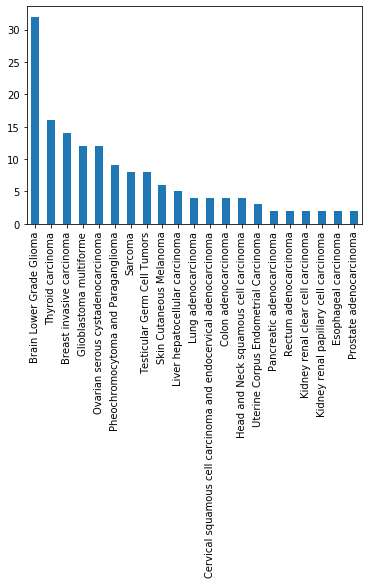

In [26]:
merged_adjusted.loc[merged_adjusted['PatientID'].apply(temp1.index[temp1 > 1].__contains__)]['CancerType'].apply(tcga_study_abbr_dict.__getitem__).value_counts().plot(kind='bar')

In [27]:
merged_adjusted

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,LF,SampleType,PatientID
7677,TCGA-2L-AAQM-01A-11R-A39D-07,PAAD,0.000000,0.000357,0.000525,0.002484,0.0,0.003330,0.000000,0.001842,...,0.002223,0.000000,0.000000,0.000004,0.452,0.014687,1.086997,0.027983,Primary Solid Tumor,TCGA-2L-AAQM
3147,TCGA-CQ-7068-01A-11R-2081-07,HNSC,0.005177,0.000000,0.001778,0.087315,0.0,0.000000,0.007622,0.037152,...,0.000000,0.000478,0.000000,0.000000,0.004,0.310781,0.975212,0.296267,Primary Solid Tumor,TCGA-CQ-7068
2511,TCGA-AA-3977-01A-01R-1022-07,COAD,0.004461,0.000000,0.006087,0.021297,0.0,0.000000,0.003875,0.024218,...,0.000000,0.027061,0.000000,0.001394,0.082,0.116592,1.041452,0.180402,Primary Solid Tumor,TCGA-AA-3977
10051,TCGA-FY-A40K-01A-11R-A23N-07,THCA,0.000085,0.006051,0.003530,0.006686,0.0,0.009487,0.000000,0.007885,...,0.003159,0.000000,0.000000,0.000000,0.008,0.304142,0.971136,0.136629,Primary Solid Tumor,TCGA-FY-A40K
7239,TCGA-57-1583-01A-01R-1566-13,OV,0.000000,0.002630,0.000000,0.000687,0.0,0.000195,0.000000,0.000585,...,0.000000,0.001716,0.000000,0.000000,0.036,0.170595,1.043919,0.019993,Primary Solid Tumor,TCGA-57-1583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,TCGA-A8-A08P-01A-11R-A00Z-07,BRCA,0.012569,0.000000,0.000282,0.047915,0.0,0.035880,0.001224,0.025133,...,0.019405,0.000000,0.000000,0.003395,0.050,0.132337,1.035299,0.367829,Primary Solid Tumor,TCGA-A8-A08P
9215,TCGA-GF-A6C8-06A-12R-A311-07,SKCM,0.006244,0.002963,0.002114,0.092359,0.0,0.000000,0.003330,0.018905,...,0.016246,0.000000,0.000000,0.000000,0.086,0.116135,1.052981,0.304616,Metastatic,TCGA-GF-A6C8
593,TCGA-D8-A3Z5-01A-41R-A24H-07,BRCA,0.002122,0.000911,0.031335,0.034705,0.0,0.000000,0.000000,0.009062,...,0.005011,0.000000,0.001423,0.000000,0.000,0.362057,0.942882,0.126655,Primary Solid Tumor,TCGA-D8-A3Z5
5784,TCGA-DD-AAEK-01A-11R-A41C-07,LIHC,0.012731,0.008284,0.000000,0.057863,0.0,0.065633,0.000000,0.022744,...,0.017023,0.000000,0.000000,0.000000,0.120,0.095130,1.054343,0.359425,Primary Solid Tumor,TCGA-DD-AAEK


## What's wrong?
Problem: The LF doesn't contain many of the matched samples.

In [28]:
f = lambda x: '-'.join(x.split('-')[0:3])
data['PatientID'] = data["SampleID"].apply(f)
leuk['PatientID'] = leuk["SampleID"].apply(f)

In [29]:
data[data.PatientID == 'TCGA-AZ-6599']

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,PatientID
2133,TCGA-AZ-6599-11A-01R-1774-07,COAD,0.009441,0.00000,0.139512,0.077417,0.0,0.077356,0.0,0.032346,...,0.0,0.000000,0.165261,0.000000,0.000000,0.0,0.01,0.225724,0.99349,TCGA-AZ-6599
2217,TCGA-AZ-6599-01A-11R-1774-07,COAD,0.035877,0.02068,0.131851,0.185755,0.0,0.272241,0.0,0.114452,...,0.0,0.014634,0.000000,0.028343,0.004044,0.0,0.01,0.236399,1.01883,TCGA-AZ-6599


In [30]:
leuk[leuk.PatientID == 'TCGA-AZ-6599']

,CancerType,SampleID,LF,PatientID
2237,COAD,TCGA-AZ-6599-01A-11D-1772-05,0.06696,TCGA-AZ-6599


In [31]:
merged_adjusted[merged_adjusted.PatientID == 'TCGA-AZ-6599']

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,LF,SampleType,PatientID
2217,TCGA-AZ-6599-01A-11R-1774-07,COAD,0.002402,0.001385,0.008829,0.012438,0.0,0.018229,0.0,0.007664,...,0.0,0.001898,0.000271,0.0,0.01,0.236399,1.01883,0.06696,Primary Solid Tumor,TCGA-AZ-6599


# Part 1: Primary Solid Tumor v. Recurrent Solid Tumor

In [32]:
required_sample_types = ['Primary Solid Tumor', 'Recurrent Solid Tumor']

def f(x):
    global z
    z = x
    pst = False;
    rst = False;
    for i in x:
        pst = True if i == 'Primary Solid Tumor' else pst
        rst = True if i == 'Recurrent Solid Tumor' else rst
    return pst and rst

f = lambda x: all(map(x.tolist().__contains__, ['Primary Solid Tumor', 'Recurrent Solid Tumor']))

mask = merged_adjusted.groupby(['PatientID'])['SampleType'].apply(f)
mask = mask.index[mask]

In [33]:
temp2.loc[mask]

PatientID     SampleType           
TCGA-06-0125  Primary Solid Tumor      1
              Recurrent Solid Tumor    1
TCGA-06-0190  Primary Solid Tumor      1
              Recurrent Solid Tumor    1
TCGA-06-0210  Primary Solid Tumor      1
                                      ..
TCGA-TQ-A8XE  Recurrent Solid Tumor    1
TCGA-VT-A80J  Primary Solid Tumor      1
              Recurrent Solid Tumor    1
TCGA-ZS-A9CF  Primary Solid Tumor      1
              Recurrent Solid Tumor    1
Name: SampleID, Length: 72, dtype: int64

In [34]:
merged_adjusted

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,LF,SampleType,PatientID
7677,TCGA-2L-AAQM-01A-11R-A39D-07,PAAD,0.000000,0.000357,0.000525,0.002484,0.0,0.003330,0.000000,0.001842,...,0.002223,0.000000,0.000000,0.000004,0.452,0.014687,1.086997,0.027983,Primary Solid Tumor,TCGA-2L-AAQM
3147,TCGA-CQ-7068-01A-11R-2081-07,HNSC,0.005177,0.000000,0.001778,0.087315,0.0,0.000000,0.007622,0.037152,...,0.000000,0.000478,0.000000,0.000000,0.004,0.310781,0.975212,0.296267,Primary Solid Tumor,TCGA-CQ-7068
2511,TCGA-AA-3977-01A-01R-1022-07,COAD,0.004461,0.000000,0.006087,0.021297,0.0,0.000000,0.003875,0.024218,...,0.000000,0.027061,0.000000,0.001394,0.082,0.116592,1.041452,0.180402,Primary Solid Tumor,TCGA-AA-3977
10051,TCGA-FY-A40K-01A-11R-A23N-07,THCA,0.000085,0.006051,0.003530,0.006686,0.0,0.009487,0.000000,0.007885,...,0.003159,0.000000,0.000000,0.000000,0.008,0.304142,0.971136,0.136629,Primary Solid Tumor,TCGA-FY-A40K
7239,TCGA-57-1583-01A-01R-1566-13,OV,0.000000,0.002630,0.000000,0.000687,0.0,0.000195,0.000000,0.000585,...,0.000000,0.001716,0.000000,0.000000,0.036,0.170595,1.043919,0.019993,Primary Solid Tumor,TCGA-57-1583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,TCGA-A8-A08P-01A-11R-A00Z-07,BRCA,0.012569,0.000000,0.000282,0.047915,0.0,0.035880,0.001224,0.025133,...,0.019405,0.000000,0.000000,0.003395,0.050,0.132337,1.035299,0.367829,Primary Solid Tumor,TCGA-A8-A08P
9215,TCGA-GF-A6C8-06A-12R-A311-07,SKCM,0.006244,0.002963,0.002114,0.092359,0.0,0.000000,0.003330,0.018905,...,0.016246,0.000000,0.000000,0.000000,0.086,0.116135,1.052981,0.304616,Metastatic,TCGA-GF-A6C8
593,TCGA-D8-A3Z5-01A-41R-A24H-07,BRCA,0.002122,0.000911,0.031335,0.034705,0.0,0.000000,0.000000,0.009062,...,0.005011,0.000000,0.001423,0.000000,0.000,0.362057,0.942882,0.126655,Primary Solid Tumor,TCGA-D8-A3Z5
5784,TCGA-DD-AAEK-01A-11R-A41C-07,LIHC,0.012731,0.008284,0.000000,0.057863,0.0,0.065633,0.000000,0.022744,...,0.017023,0.000000,0.000000,0.000000,0.120,0.095130,1.054343,0.359425,Primary Solid Tumor,TCGA-DD-AAEK


Text(0, 0.5, 'Number of patients')

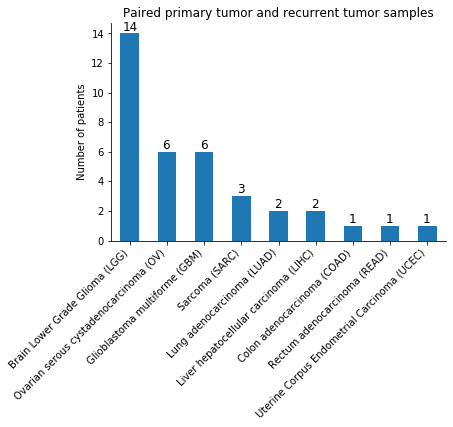

In [35]:
temp0 = merged_adjusted.loc[merged_adjusted['PatientID'].apply(mask.__contains__)].groupby(['CancerType', 'PatientID', 'SampleType'])[['SampleID']].count().reset_index()
temp0 = temp0.groupby(['CancerType', 'PatientID'])[['SampleType']].count().reset_index()
ax = temp0.CancerType.apply(tcga_study_abbr_dict2.__getitem__).value_counts().plot(kind = 'bar', title = 'Paired primary tumor and recurrent tumor samples')
for i in ax.patches:
    ax.text(i.get_x() - .07 * len(str(i.get_height())) + 0.2, i.get_height()+0.2, str(i.get_height()), fontsize=12)
#ax.invert_yaxis()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("Number of patients")

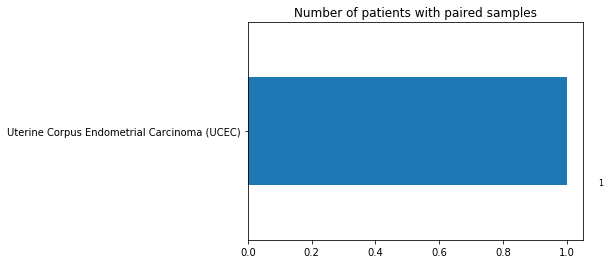

In [36]:
ax = temp.CancerType.apply(tcga_study_abbr_dict2.__getitem__).value_counts().plot(kind = 'barh', title = 'Number of patients with paired samples')
for i in ax.patches:
    ax.text(i.get_width()+.1, i.get_y()+.5, str(round((i.get_width()), 2)), fontsize=8)
ax.invert_yaxis()

In [37]:
merged_adjusted.loc[merged_adjusted['PatientID'].apply(mask.__contains__)]['CancerType'].apply(tcga_study_abbr_dict.__getitem__).value_counts()

Brain Lower Grade Glioma                32
Glioblastoma multiforme                 12
Ovarian serous cystadenocarcinoma       12
Sarcoma                                  6
Liver hepatocellular carcinoma           5
Lung adenocarcinoma                      4
Uterine Corpus Endometrial Carcinoma     3
Colon adenocarcinoma                     2
Rectum adenocarcinoma                    2
Name: CancerType, dtype: int64

In [38]:
class DisplayRows:
    def __enter__(self, n = None):
        self.old_n = pd.get_option('display.max_rows')
        #self.old_max_colwidth = pd.get_option("display.max_colwidth")
        #pd.set_option("display.expand_frame_repr", 1000)
        pd.set_option('display.max_rows', n)
        
    def __exit__(self, type, value, traceback):
        pd.set_option('display.max_rows', self.old_n)
        #pd.set_option("display.max_colwidth", self.old_max_colwidth)

merged_adjusted.SampleID = merged_adjusted.SampleID.apply(lambda x: x.replace('-', '.'))
merged_adjusted.PatientID = merged_adjusted.PatientID.apply(lambda x: x.replace('-', '.'))
merged_adjusted.SampleType = merged_adjusted.SampleType.apply(lambda x: x.replace(' ', '.'))
mask = list(map(lambda x: x.replace('-', '.'), mask))


In [39]:
with DisplayRows():
    display(merged_adjusted.loc[merged_adjusted['PatientID'].apply(mask.__contains__)].groupby(['CancerType', 'PatientID', 'SampleType', 'SampleID']).first())


B.cells.naive  \
CancerType PatientID    SampleType            SampleID                                      
COAD       TCGA.G4.6317 Primary.Solid.Tumor   TCGA.G4.6317.01A.11R.1723.07       0.000410   
                        Recurrent.Solid.Tumor TCGA.G4.6317.02A.11R.2066.07       0.000043   
GBM        TCGA.06.0125 Primary.Solid.Tumor   TCGA.06.0125.01A.01R.1849.01       0.000881   
                        Recurrent.Solid.Tumor TCGA.06.0125.02A.11R.2005.01       0.000000   
           TCGA.06.0190 Primary.Solid.Tumor   TCGA.06.0190.01A.01R.1849.01       0.000000   
                        Recurrent.Solid.Tumor TCGA.06.0190.02A.01R.2005.01       0.000000   
           TCGA.06.0210 Primary.Solid.Tumor   TCGA.06.0210.01A.01R.1849.01       0.000828   
                        Recurrent.Solid.Tumor TCGA.06.0210.02A.01R.2005.01       0.000192   
           TCGA.06.0211 Primary.Solid.Tumor   TCGA.06.0211.01A.01R.1849.01       0.000427   
                        Recurrent.Solid.Tumor TCGA.06.0211.02A.02R.2005.01       0.001229   
           TCGA.14.1034 Primary.Solid.Tumor   TCGA.14.1034.01A.01R.1849.01       0.000000   
                        Recurrent.Solid.Tumor TCGA.14.1034.02B.01R.2005.01       0.000000   
           TCGA.19.4065 Primary.Solid.Tumor   TCGA.19.4065.01A.01R.2005.01       0.000000   
                        Recurrent.Solid.Tumor TCGA.19.4065.02A.11R.2005.01       0.000000   
LGG        TCGA.DH.A669 Primary.Solid.Tumor   TCGA.DH.A669.01A.12R.A31N.07       0.000182   
                        Recurrent.Solid.Tumor TCGA.DH.A669.02A.11R.A31N.07       0.000000   
           TCGA.DU.5870 Primary.Solid.Tumor   TCGA.DU.5870.01A.11R.1708.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.DU.5870.02A.12R.A36H.07       0.000000   
           TCGA.DU.5872 Primary.Solid.Tumor   TCGA.DU.5872.01A.11R.1708.07       0.003720   
                        Recurrent.Solid.Tumor TCGA.DU.5872.02A.21R.A36H.07       0.000000   
           TCGA.DU.6397 Primary.Solid.Tumor   TCGA.DU.6397.01A.11R.1708.07       0.000946   
                        Recurrent.Solid.Tumor TCGA.DU.6397.02A.12R.A36H.07       0.000183   
           TCGA.DU.6404 Primary.Solid.Tumor   TCGA.DU.6404.01A.11R.1708.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.DU.6404.02A.21R.A36H.07       0.001604   
                                              TCGA.DU.6404.02B.11R.A36H.07       0.001507   
           TCGA.DU.6407 Primary.Solid.Tumor   TCGA.DU.6407.01A.13R.1708.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.DU.6407.02A.12R.A36H.07       0.000000   
                                              TCGA.DU.6407.02B.11R.A36H.07       0.000510   
           TCGA.DU.7304 Primary.Solid.Tumor   TCGA.DU.7304.01A.12R.2090.07       0.000331   
                        Recurrent.Solid.Tumor TCGA.DU.7304.02A.12R.A36H.07       0.000784   
           TCGA.FG.5963 Primary.Solid.Tumor   TCGA.FG.5963.01A.11R.1708.07       0.000209   
                        Recurrent.Solid.Tumor TCGA.FG.5963.02A.12R.A29R.07       0.001399   
           TCGA.FG.5965 Primary.Solid.Tumor   TCGA.FG.5965.01B.11R.1896.07       0.001096   
                        Recurrent.Solid.Tumor TCGA.FG.5965.02A.11R.A29R.07       0.001244   
                                              TCGA.FG.5965.02B.11R.A29R.07       0.000000   
           TCGA.FG.A4MT Primary.Solid.Tumor   TCGA.FG.A4MT.01A.11R.A26U.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.FG.A4MT.02A.11R.A29R.07       0.000000   
           TCGA.TM.A7CF Primary.Solid.Tumor   TCGA.TM.A7CF.01A.11R.A32Q.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.TM.A7CF.02A.11R.A32Q.07       0.000000   
           TCGA.TQ.A7RK Primary.Solid.Tumor   TCGA.TQ.A7RK.01A.11R.A33Z.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.TQ.A7RK.02A.11R.A36H.07       0.000663   
                                              TCGA.TQ.A7RK.02B.11R.A40A.07   

In [40]:
merged_adjusted[merged_adjusted['CancerType'].apply(mask.__contains__)].groupby(['CancerType', 'PatientID', 'SampleType'])

In [41]:
lgg = merged_adjusted[(merged_adjusted['CancerType'] == 'LGG') & (merged_adjusted['PatientID'].apply(mask.__contains__))]
cell_types = lgg.columns[2:24].tolist()
cell_types

['B.cells.naive',
 'B.cells.memory',
 'Plasma.cells',
 'T.cells.CD8',
 'T.cells.CD4.naive',
 'T.cells.CD4.memory.resting',
 'T.cells.CD4.memory.activated',
 'T.cells.follicular.helper',
 'T.cells.regulatory..Tregs.',
 'T.cells.gamma.delta',
 'NK.cells.resting',
 'NK.cells.activated',
 'Monocytes',
 'Macrophages.M0',
 'Macrophages.M1',
 'Macrophages.M2',
 'Dendritic.cells.resting',
 'Dendritic.cells.activated',
 'Mast.cells.resting',
 'Mast.cells.activated',
 'Eosinophils',
 'Neutrophils']

In [42]:
with DisplayRows():
    display(lgg.sort_values(['SampleID']))

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,LF,SampleType,PatientID
5148,TCGA.DH.A669.01A.12R.A31N.07,LGG,0.000182,0.000985,0.000000,0.002332,0.000000,0.012117,0.0,0.001876,...,0.002601,0.000000,0.000000,0.000000,0.206,0.075694,1.059359,0.046088,Primary.Solid.Tumor,TCGA.DH.A669
5153,TCGA.DH.A669.02A.11R.A31N.07,LGG,0.000000,0.001801,0.000000,0.001219,0.000000,0.003125,0.0,0.001248,...,0.000000,0.003005,0.000000,0.000042,0.060,0.140233,1.053477,0.048633,Recurrent.Solid.Tumor,TCGA.DH.A669
5087,TCGA.DU.5870.01A.11R.1708.07,LGG,0.000000,0.010366,0.000000,0.000000,0.007732,0.000000,0.0,0.004072,...,0.000000,0.000000,0.000000,0.000201,0.064,0.138913,1.059132,0.134695,Primary.Solid.Tumor,TCGA.DU.5870
5347,TCGA.DU.5870.02A.12R.A36H.07,LGG,0.000000,0.000606,0.000001,0.002590,0.002500,0.001767,0.0,0.001027,...,0.005398,0.000000,0.000000,0.000015,0.672,0.012037,1.094636,0.046789,Recurrent.Solid.Tumor,TCGA.DU.5870
5092,TCGA.DU.5872.01A.11R.1708.07,LGG,0.003720,0.000000,0.003170,0.001249,0.000000,0.002402,0.0,0.002255,...,0.000000,0.006594,0.000000,0.002491,0.058,0.142062,1.047447,0.085155,Primary.Solid.Tumor,TCGA.DU.5872
5354,TCGA.DU.5872.02A.21R.A36H.07,LGG,0.000000,0.000341,0.007029,0.041396,0.000000,0.019669,0.0,0.038851,...,0.006677,0.009927,0.000000,0.001802,0.012,0.226089,1.005368,0.575829,Recurrent.Solid.Tumor,TCGA.DU.5872
5102,TCGA.DU.6397.01A.11R.1708.07,LGG,0.000946,0.000829,0.002210,0.003907,0.002963,0.001835,0.0,0.000506,...,0.000000,0.004091,0.000000,0.002332,0.108,0.107858,1.070028,0.071923,Primary.Solid.Tumor,TCGA.DU.6397
5353,TCGA.DU.6397.02A.12R.A36H.07,LGG,0.000183,0.000169,0.000000,0.001539,0.000000,0.007528,0.0,0.001529,...,0.003751,0.000000,0.000000,0.000000,0.712,0.006315,1.090874,0.040540,Recurrent.Solid.Tumor,TCGA.DU.6397
5116,TCGA.DU.6404.01A.11R.1708.07,LGG,0.000000,0.000000,0.001319,0.018294,0.000000,0.014651,0.0,0.007534,...,0.000000,0.007253,0.000983,0.000000,0.218,0.072508,1.065983,0.122952,Primary.Solid.Tumor,TCGA.DU.6404
5352,TCGA.DU.6404.02A.21R.A36H.07,LGG,0.001604,0.000000,0.000000,0.040754,0.000000,0.034725,0.0,0.012773,...,0.058685,0.000000,0.000106,0.000790,0.420,0.040215,1.068368,0.289841,Recurrent.Solid.Tumor,TCGA.DU.6404


In [43]:
lgg.groupby("SampleType").corr()

B.cells.naive  \
SampleType                                                          
Primary.Solid.Tumor   B.cells.naive                      1.000000   
                      B.cells.memory                    -0.238445   
                      Plasma.cells                       0.775206   
                      T.cells.CD8                       -0.128765   
                      T.cells.CD4.naive                 -0.278530   
                      T.cells.CD4.memory.resting        -0.146854   
                      T.cells.CD4.memory.activated            NaN   
                      T.cells.follicular.helper         -0.008368   
                      T.cells.regulatory..Tregs.        -0.156596   
                      T.cells.gamma.delta                     NaN   
                      NK.cells.resting                  -0.264249   
                      NK.cells.activated                 0.269646   
                      Monocytes                         -0.029523   
                      Macrophages.M0                    -0.143709   
                      Macrophages.M1                     0.440739   
                      Macrophages.M2                     0.060531   
                      Dendritic.cells.resting            0.104505   
                      Dendritic.cells.activated         -0.132713   
                      Mast.cells.resting                -0.182828   
                      Mast.cells.activated               0.281369   
                      Eosinophils                       -0.132713   
                      Neutrophils                        0.379630   
                      P.value                           -0.236627   
                      Correlation                        0.203476   
                      RMSE                              -0.262147   
                      LF                                 0.040997   
Recurrent.Solid.Tumor B.cells.naive                      1.000000   
                      B.cells.memory                    -0.514300   
                      Plasma.cells                      -0.209045   
                      T.cells.CD8                        0.291703   
                      T.cells.CD4.naive                 -0.445001   
                      T.cells.CD4.memory.resting         0.441245   
                      T.cells.CD4.memory.activated            NaN   
                      T.cells.follicular.helper         -0.044387   
                      T.cells.regulatory..Tregs.         0.090130   
                      T.cells.gamma.delta                     NaN   
                      NK.cells.resting                   0.321776   
                      NK.cells.activated                -0.116314   
                      Monocytes                         -0.262466   
                      Macrophages.M0                     0.487921   
                      Macrophages.M1                     0.028914   
                      Macrophages.M2                    -0.131263   
                      Dendritic.cells.resting           -0.203138   
                      Dendritic.cells.activated          0.003954   
                      Mast.cells.resting                 0.521256   
                      Mast.cells.activated              -0.258351   
                      Eosinophils                       -0.203476   
                      Neutrophils                        0.240261   
                      P.value                            0.097675   
                      Correlation                       -0.176244   
                      RMSE                               0.148137   
                      LF                                 0.015120   

                                                    B.cells.memory  \
SampleType                                                           
Primary.Solid.Tumor   B.cells.naive                      -0.238445   
                      B.cells.memory                      1.000000   
                      Plasma.cells           

In [44]:
{i: np.corrcoef(lgg[lgg.SampleType == 'Primary Solid Tumor'][i], lgg[lgg.SampleType == 'Recurrent Solid Tumor'][i])[1, 0] for i in cell_types}

/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


{'B.cells.naive': nan,
 'B.cells.memory': nan,
 'Plasma.cells': nan,
 'T.cells.CD8': nan,
 'T.cells.CD4.naive': nan,
 'T.cells.CD4.memory.resting': nan,
 'T.cells.CD4.memory.activated': nan,
 'T.cells.follicular.helper': nan,
 'T.cells.regulatory..Tregs.': nan,
 'T.cells.gamma.delta': nan,
 'NK.cells.resting': nan,
 'NK.cells.activated': nan,
 'Monocytes': nan,
 'Macrophages.M0': nan,
 'Macrophages.M1': nan,
 'Macrophages.M2': nan,
 'Dendritic.cells.resting': nan,
 'Dendritic.cells.activated': nan,
 'Mast.cells.resting': nan,
 'Mast.cells.activated': nan,
 'Eosinophils': nan,
 'Neutrophils': nan}

In [45]:
with DisplayRows():
    display(lgg[lgg.SampleType == 'Primary Solid Tumor']['B.cells.naive'])

Series([], Name: B.cells.naive, dtype: float64)

In [46]:
with DisplayRows():
    display(lgg[lgg.SampleType == 'Recurrent Solid Tumor']['B.cells.naive'])

Series([], Name: B.cells.naive, dtype: float64)

## Correlation and its confidence interval

\begin{align}
r & = \frac{\sum{x_{0i} x_{1i}} - n\bar{x}_0 \bar{x}_1)}{\sqrt{(\sum{}x_{0i}^2-n\bar{x}_0^2)(\sum{x_{1i}^2} - n\bar{x}_1^2)}}\\
r_L, r_U & = \tanh⁡{(\text{arc}\tanh⁡{r} \pm \frac{z_{1-\alpha/2}}{\sqrt{n-3}})}
\end{align}

In [47]:
def corr(x, y):
    return np.corrcoef(x, y)[1, 0]

def corr_ci(r, n, a, which = 'both'):
    if (r == float('nan')):
        return float('nan')
    if (n < 3):
        if which == 'both':
            return [-1, 1]
        elif which == 'lower':
            return -1
        elif which == 'upper':
            return 1
        else:
            raise ValueError("which must be lower, upper, or both")
    
    z_critical = scipy.stats.norm.ppf(1 - a / 2)
    z_r = np.log((1 + r) / (1 - r)) / 2
    se = 1 / np.sqrt(n - 3)
    if which == 'both':
        return list(map(np.tanh, [z_r - z_critical * se, z_r + z_critical * se]))
    elif which == 'lower':
        return np.tanh(z_r - z_critical * se)
    elif which == 'upper':
        return np.tanh(z_r + z_critical * se)
    else:
        raise ValueError("which must be lower, upper, or both")

### Brain Lower Grade Glioma (LGG)

Some patient-sample time has more than one sample.

In [48]:
with DisplayRows():
    display(lgg.groupby(['CancerType', 'PatientID', 'SampleType', 'SampleID']).first())

B.cells.naive  \
CancerType PatientID    SampleType            SampleID                                      
LGG        TCGA.DH.A669 Primary.Solid.Tumor   TCGA.DH.A669.01A.12R.A31N.07       0.000182   
                        Recurrent.Solid.Tumor TCGA.DH.A669.02A.11R.A31N.07       0.000000   
           TCGA.DU.5870 Primary.Solid.Tumor   TCGA.DU.5870.01A.11R.1708.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.DU.5870.02A.12R.A36H.07       0.000000   
           TCGA.DU.5872 Primary.Solid.Tumor   TCGA.DU.5872.01A.11R.1708.07       0.003720   
                        Recurrent.Solid.Tumor TCGA.DU.5872.02A.21R.A36H.07       0.000000   
           TCGA.DU.6397 Primary.Solid.Tumor   TCGA.DU.6397.01A.11R.1708.07       0.000946   
                        Recurrent.Solid.Tumor TCGA.DU.6397.02A.12R.A36H.07       0.000183   
           TCGA.DU.6404 Primary.Solid.Tumor   TCGA.DU.6404.01A.11R.1708.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.DU.6404.02A.21R.A36H.07       0.001604   
                                              TCGA.DU.6404.02B.11R.A36H.07       0.001507   
           TCGA.DU.6407 Primary.Solid.Tumor   TCGA.DU.6407.01A.13R.1708.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.DU.6407.02A.12R.A36H.07       0.000000   
                                              TCGA.DU.6407.02B.11R.A36H.07       0.000510   
           TCGA.DU.7304 Primary.Solid.Tumor   TCGA.DU.7304.01A.12R.2090.07       0.000331   
                        Recurrent.Solid.Tumor TCGA.DU.7304.02A.12R.A36H.07       0.000784   
           TCGA.FG.5963 Primary.Solid.Tumor   TCGA.FG.5963.01A.11R.1708.07       0.000209   
                        Recurrent.Solid.Tumor TCGA.FG.5963.02A.12R.A29R.07       0.001399   
           TCGA.FG.5965 Primary.Solid.Tumor   TCGA.FG.5965.01B.11R.1896.07       0.001096   
                        Recurrent.Solid.Tumor TCGA.FG.5965.02A.11R.A29R.07       0.001244   
                                              TCGA.FG.5965.02B.11R.A29R.07       0.000000   
           TCGA.FG.A4MT Primary.Solid.Tumor   TCGA.FG.A4MT.01A.11R.A26U.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.FG.A4MT.02A.11R.A29R.07       0.000000   
           TCGA.TM.A7CF Primary.Solid.Tumor   TCGA.TM.A7CF.01A.11R.A32Q.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.TM.A7CF.02A.11R.A32Q.07       0.000000   
           TCGA.TQ.A7RK Primary.Solid.Tumor   TCGA.TQ.A7RK.01A.11R.A33Z.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.TQ.A7RK.02A.11R.A36H.07       0.000663   
                                              TCGA.TQ.A7RK.02B.11R.A40A.07       0.000056   
           TCGA.TQ.A7RV Primary.Solid.Tumor   TCGA.TQ.A7RV.01A.21R.A34F.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.TQ.A7RV.02A.11R.A36H.07       0.000000   
           TCGA.TQ.A8XE Primary.Solid.Tumor   TCGA.TQ.A8XE.01A.11R.A36H.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.TQ.A8XE.02A.11R.A36H.07       0.000935   

                                                                            B.cells.memory  \
CancerType PatientID    SampleType            SampleID                                       
LGG        TCGA.DH.A669 Primary.Solid.Tumor   TCGA.DH.A669.01A.12R.A31N.07        0.000985   
                        Recurrent.Solid.Tumor TCGA.DH.A669.02A.11R.A31N.07        0.001801   
           TCGA.DU.5870 Primary.Solid.Tumor   TCGA.DU.5870.01A.11R.1708.07        0.010366   
                        Recurrent.Solid.Tumor TCGA.DU.5870.02A.12R.A36H.07        0.000606   
           TCGA.DU.5872 Primary.Solid.Tumor   TCGA.DU.5872.01A.11R.1708.07        0.000000   
                        Recurrent.Solid.Tumor TCGA.DU.5872.02A.21R.A36H.07        0.000341   
           TCGA.DU.6397 Primary.Solid.Tumor   TCGA.DU.6397.01A.11R.1708.07        0.000829   
                        Recurrent.Solid.Tumor TCGA.DU.6397.02A.12R.

We simply take the mean.

In [49]:
lgg_mean = lgg.groupby(['CancerType', 'PatientID', 'SampleType']).mean()
lgg_mean

B.cells.naive  B.cells.memory  \
CancerType PatientID    SampleType                                             
LGG        TCGA.DH.A669 Primary.Solid.Tumor         0.000182        0.000985   
                        Recurrent.Solid.Tumor       0.000000        0.001801   
           TCGA.DU.5870 Primary.Solid.Tumor         0.000000        0.010366   
                        Recurrent.Solid.Tumor       0.000000        0.000606   
           TCGA.DU.5872 Primary.Solid.Tumor         0.003720        0.000000   
                        Recurrent.Solid.Tumor       0.000000        0.000341   
           TCGA.DU.6397 Primary.Solid.Tumor         0.000946        0.000829   
                        Recurrent.Solid.Tumor       0.000183        0.000169   
           TCGA.DU.6404 Primary.Solid.Tumor         0.000000        0.000000   
                        Recurrent.Solid.Tumor       0.001555        0.000000   
           TCGA.DU.6407 Primary.Solid.Tumor         0.000000        0.000850   
                        Recurrent.Solid.Tumor       0.000255        0.001582   
           TCGA.DU.7304 Primary.Solid.Tumor         0.000331        0.001100   
                        Recurrent.Solid.Tumor       0.000784        0.000000   
           TCGA.FG.5963 Primary.Solid.Tumor         0.000209        0.000000   
                        Recurrent.Solid.Tumor       0.001399        0.000000   
           TCGA.FG.5965 Primary.Solid.Tumor         0.001096        0.001680   
                        Recurrent.Solid.Tumor       0.000622        0.000626   
           TCGA.FG.A4MT Primary.Solid.Tumor         0.000000        0.000774   
                        Recurrent.Solid.Tumor       0.000000        0.008021   
           TCGA.TM.A7CF Primary.Solid.Tumor         0.000000        0.003411   
                        Recurrent.Solid.Tumor       0.000000        0.006895   
           TCGA.TQ.A7RK Primary.Solid.Tumor         0.000000        0.000384   
                        Recurrent.Solid.Tumor       0.000360        0.000047   
           TCGA.TQ.A7RV Primary.Solid.Tumor         0.000000        0.002734   
                        Recurrent.Solid.Tumor       0.000000        0.004973   
           TCGA.TQ.A8XE Primary.Solid.Tumor         0.000000        0.001675   
                        Recurrent.Solid.Tumor       0.000935        0.000000   

                                               Plasma.cells  T.cells.CD8  \
CancerType PatientID    SampleType                                         
LGG        TCGA.DH.A669 Primary.Solid.Tumor        0.000000     0.002332   
                        Recurrent.Solid.Tumor      0.000000     0.001219   
           TCGA.DU.5870 Primary.Solid.Tumor        0.000000     0.000000   
                        Recurrent.Solid.Tumor      0.000001     0.002590   
           TCGA.DU.5872 Primary.Solid.Tumor        0.003170     0.001249   
                        Recurrent.Solid.Tumor      0.007029     0.041396   
           TCGA.DU.6397 Primary.Solid.Tumor        0.002210     0.003907   
                        Recurrent.Solid.Tumor      0.000000     0.001539   
           TCGA.DU.6404 Primary.Solid.Tumor        0.001319     0.018294   
                        Recurrent.Solid.Tumor      0.000115     0.022739   
           TCGA.DU.6407 Primary.Solid.Tumor        0.000000     0.000299   
                        Recurrent.Solid.Tumor      0.000000     0.002827   
           TCGA.DU.7304 Primary.Solid.Tumor        0.000000     0.001306   
                        Recurrent.Solid.Tumor      0.000000     0.000585   
           TCGA.FG.5963 Primary.Solid.Tumor        0.001188     0.017383   
                        Recurrent.Solid.Tumor      0.000000     0.012285   
           TCGA.FG.5965 Primary.Solid.Tumor        0.000000     0.005208   
                        Recurrent.Solid.Tumor      0.000000     0.010649   
           TCGA.FG.A4MT Primary.Solid.Tumor        0.000000     0.000117   
                        Recurrent.Solid.Tumor     

In [50]:
lgg_mean['T.cells.all'] = lgg_mean[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

lgg_mean['B.cells.all'] = lgg_mean[['B.cells.naive', 'B.cells.memory']].sum(1)

lgg_mean['Nk.cells.all'] = lgg_mean[['NK.cells.resting', 'NK.cells.activated']].sum(1)

lgg_mean['Macrophages.all'] = lgg_mean[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

lgg_mean['Dendritic.cells.all'] = lgg_mean[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

lgg_mean['Mast.cells.all'] = lgg_mean[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)

lgg_mean['Leukocytes.all'] = lgg_mean[cell_types].sum(1)

In [51]:
augmented_cell_types = cell_types + ['T.cells.all', 'B.cells.all', 'Nk.cells.all', 'Macrophages.all', 
                                     'Dendritic.cells.all', 'Mast.cells.all', 'Leukocytes.all']

In [52]:
lgg_mean_primary = lgg_mean.reset_index()[lgg_mean.reset_index().SampleType == 'Primary.Solid.Tumor']
lgg_mean_recurrent = lgg_mean.reset_index()[lgg_mean.reset_index().SampleType == 'Recurrent.Solid.Tumor']

In [53]:
display(lgg_mean_primary)
display(lgg_mean_recurrent)

,CancerType,PatientID,SampleType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,...,Correlation,RMSE,LF,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all,Leukocytes.all
0,LGG,TCGA.DH.A669,Primary.Solid.Tumor,0.000182,0.000985,0.000000,0.002332,0.000000,0.012117,0.0,...,0.075694,1.059359,0.046088,0.016352,0.001167,0.001204,0.022747,0.000000,0.002601,0.046088
2,LGG,TCGA.DU.5870,Primary.Solid.Tumor,0.000000,0.010366,0.000000,0.000000,0.007732,0.000000,0.0,...,0.138913,1.059132,0.134695,0.011804,0.010366,0.002141,0.064423,0.000000,0.000000,0.134695
4,LGG,TCGA.DU.5872,Primary.Solid.Tumor,0.003720,0.000000,0.003170,0.001249,0.000000,0.002402,0.0,...,0.142062,1.047447,0.085155,0.005907,0.003720,0.002593,0.049549,0.000000,0.006594,0.085155
6,LGG,TCGA.DU.6397,Primary.Solid.Tumor,0.000946,0.000829,0.002210,0.003907,0.002963,0.001835,0.0,...,0.107858,1.070028,0.071923,0.009211,0.001776,0.000309,0.045578,0.000114,0.004091,0.071923
8,LGG,TCGA.DU.6404,Primary.Solid.Tumor,0.000000,0.000000,0.001319,0.018294,0.000000,0.014651,0.0,...,0.072508,1.065983,0.122952,0.042877,0.000000,0.009108,0.054604,0.000028,0.007253,0.122952
10,LGG,TCGA.DU.6407,Primary.Solid.Tumor,0.000000,0.000850,0.000000,0.000299,0.000580,0.001130,0.0,...,0.132627,1.077870,0.044397,0.002009,0.000850,0.001042,0.027992,0.000000,0.001781,0.044397
12,LGG,TCGA.DU.7304,Primary.Solid.Tumor,0.000331,0.001100,0.000000,0.001306,0.003968,0.004141,0.0,...,0.220699,1.028181,0.112941,0.009415,0.001431,0.003498,0.073785,0.000000,0.003700,0.112941
14,LGG,TCGA.FG.5963,Primary.Solid.Tumor,0.000209,0.000000,0.001188,0.017383,0.000000,0.022681,0.0,...,0.264296,1.000702,0.238586,0.045866,0.000209,0.002150,0.169529,0.000000,0.000322,0.238586
16,LGG,TCGA.FG.5965,Primary.Solid.Tumor,0.001096,0.001680,0.000000,0.005208,0.000000,0.009390,0.0,...,0.194881,1.026508,0.129000,0.014597,0.002776,0.001934,0.044919,0.000000,0.030602,0.129000
18,LGG,TCGA.FG.A4MT,Primary.Solid.Tumor,0.000000,0.000774,0.000000,0.000117,0.001472,0.002348,0.0,...,0.103917,1.077478,0.032370,0.003937,0.000774,0.001877,0.020551,0.000000,0.001062,0.032370


,CancerType,PatientID,SampleType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,...,Correlation,RMSE,LF,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all,Leukocytes.all
1,LGG,TCGA.DH.A669,Recurrent.Solid.Tumor,0.000000,0.001801,0.000000,0.001219,0.000000,0.003125,0.0,...,0.140233,1.053477,0.048633,0.005592,0.001801,0.003220,0.029165,0.000268,0.003005,0.048633
3,LGG,TCGA.DU.5870,Recurrent.Solid.Tumor,0.000000,0.000606,0.000001,0.002590,0.002500,0.001767,0.0,...,0.012037,1.094636,0.046789,0.007884,0.000606,0.004938,0.025974,0.000000,0.005398,0.046789
5,LGG,TCGA.DU.5872,Recurrent.Solid.Tumor,0.000000,0.000341,0.007029,0.041396,0.000000,0.019669,0.0,...,0.226089,1.005368,0.575829,0.107562,0.000341,0.042455,0.335193,0.050121,0.016604,0.575829
7,LGG,TCGA.DU.6397,Recurrent.Solid.Tumor,0.000183,0.000169,0.000000,0.001539,0.000000,0.007528,0.0,...,0.006315,1.090874,0.040540,0.010998,0.000352,0.007345,0.015014,0.000000,0.003751,0.040540
9,LGG,TCGA.DU.6404,Recurrent.Solid.Tumor,0.001555,0.000000,0.000115,0.022739,0.000063,0.019509,0.0,...,-0.002387,1.084440,0.162392,0.052404,0.001555,0.016362,0.049666,0.000059,0.031783,0.162392
11,LGG,TCGA.DU.6407,Recurrent.Solid.Tumor,0.000255,0.001582,0.000000,0.002827,0.000000,0.001816,0.0,...,0.265813,1.007536,0.084397,0.005980,0.001837,0.002597,0.056768,0.000000,0.004642,0.084397
13,LGG,TCGA.DU.7304,Recurrent.Solid.Tumor,0.000784,0.000000,0.000000,0.000585,0.000521,0.003752,0.0,...,0.023219,1.075905,0.023924,0.005300,0.000784,0.001962,0.008817,0.000000,0.005687,0.023924
15,LGG,TCGA.FG.5963,Recurrent.Solid.Tumor,0.001399,0.000000,0.000000,0.012285,0.000000,0.017047,0.0,...,0.047715,1.098758,0.152312,0.034324,0.001399,0.000695,0.102765,0.000000,0.003291,0.152312
17,LGG,TCGA.FG.5965,Recurrent.Solid.Tumor,0.000622,0.000626,0.000000,0.010649,0.003822,0.000823,0.0,...,0.088869,1.070646,0.092208,0.021995,0.001248,0.007248,0.050053,0.000426,0.007727,0.092208
19,LGG,TCGA.FG.A4MT,Recurrent.Solid.Tumor,0.000000,0.008021,0.000000,0.003191,0.002383,0.000714,0.0,...,0.180726,1.033160,0.121557,0.011658,0.008021,0.002445,0.059865,0.000096,0.024515,0.121557


In [54]:
len(lgg_mean_primary)

14

In [55]:
lgg_corr = {i: corr(lgg_mean_primary[i], lgg_mean_recurrent[i]) for i in augmented_cell_types}
lgg_corr

/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


{'B.cells.naive': -0.19965566812631189,
 'B.cells.memory': 0.1002031961504769,
 'Plasma.cells': 0.7355879708751762,
 'T.cells.CD8': 0.3321889614472223,
 'T.cells.CD4.naive': 0.11756756649375405,
 'T.cells.CD4.memory.resting': 0.3736445983841174,
 'T.cells.CD4.memory.activated': nan,
 'T.cells.follicular.helper': 0.19054953243637174,
 'T.cells.regulatory..Tregs.': 0.14495815190393085,
 'T.cells.gamma.delta': nan,
 'NK.cells.resting': 0.4832950308839103,
 'NK.cells.activated': 0.33967488161106696,
 'Monocytes': -0.35118155095663717,
 'Macrophages.M0': 0.048986101840462155,
 'Macrophages.M1': 0.5820489985139075,
 'Macrophages.M2': -0.0057356519620806795,
 'Dendritic.cells.resting': -0.09464750354633933,
 'Dendritic.cells.activated': 0.679374875755893,
 'Mast.cells.resting': -0.23382458014289947,
 'Mast.cells.activated': -0.08788072355226226,
 'Eosinophils': -0.10321852934826,
 'Neutrophils': 0.07675507432126824,
 'T.cells.all': 0.23688879026760487,
 'B.cells.all': -0.09144695363927495,
 '

In [56]:
lgg_corr_ci = {k: corr_ci(v, len(lgg_mean_primary), 0.05) for k, v in lgg_corr.items()}
lgg_corr_ci

{'B.cells.naive': [-0.6602886750241208, 0.3701332341869962],
 'B.cells.memory': [-0.454542399370422, 0.598939617527835],
 'Plasma.cells': [0.3362381495155506, 0.910723220503354],
 'T.cells.CD8': [-0.2408390655300002, 0.733489068948206],
 'T.cells.CD4.naive': [-0.44048918486824723, 0.6100902832586117],
 'T.cells.CD4.memory.resting': [-0.19573999996440883, 0.7546217279635214],
 'T.cells.CD4.memory.activated': [nan, nan],
 'T.cells.follicular.helper': [-0.378274117378554, 0.6549159360906337],
 'T.cells.regulatory..Tregs.': [-0.41775137054810824, 0.6272915194035714],
 'T.cells.gamma.delta': [nan, nan],
 'NK.cells.resting': [-0.06359084559468695, 0.8069509710214307],
 'NK.cells.activated': [-0.23287427816418166, 0.7373634102865697],
 'Monocytes': [-0.7432681060254457, 0.22047991519931442],
 'Macrophages.M0': [-0.4944445188141641, 0.5648836999386917],
 'Macrophages.M1': [0.07446647669498956, 0.850098350305246],
 'Macrophages.M2': [-0.5346879816557933, 0.5264459410336279],
 'Dendritic.cells.r

In [57]:
pd.DataFrame({'95% CI Lower': {k: v[0] for k, v in lgg_corr_ci.items()},
              'Correlation': lgg_corr, 
              '95% CI Upper': {k: v[1] for k, v in lgg_corr_ci.items()}}).style.apply(lambda x: ["color: red" if v > 0.0 else "" for v in x], axis = 1)

,95% CI Lower,Correlation,95% CI Upper
B.cells.naive,-0.660289,-0.199656,0.370133
B.cells.memory,-0.454542,0.100203,0.598940
Plasma.cells,0.336238,0.735588,0.910723
T.cells.CD8,-0.240839,0.332189,0.733489
T.cells.CD4.naive,-0.440489,0.117568,0.610090
T.cells.CD4.memory.resting,-0.195740,0.373645,0.754622
T.cells.CD4.memory.activated,nan,nan,nan
T.cells.follicular.helper,-0.378274,0.190550,0.654916
T.cells.regulatory..Tregs.,-0.417751,0.144958,0.627292
T.cells.gamma.delta,nan,nan,nan


In [58]:
pd.DataFrame({'95% CI Lower': {k: v[0] for k, v in lgg_corr_ci.items()},
              'Correlation': lgg_corr, 
              '95% CI Upper': {k: v[1] for k, v in lgg_corr_ci.items()}}).to_csv("lgg.csv")

Apparently, the 95% confidence interval is too large to make useful predictions. Other cancer types which have less samples will be worse. Thus, let's move on to the next part.

## GBM

In [59]:
gbm = merged_adjusted[(merged_adjusted['CancerType'] == 'GBM') & (merged_adjusted['PatientID'].apply(mask.__contains__))]

In [60]:
with DisplayRows():
    display(gbm.groupby(['CancerType', 'PatientID', 'SampleType', 'SampleID']).first())

B.cells.naive  \
CancerType PatientID    SampleType            SampleID                                      
GBM        TCGA.06.0125 Primary.Solid.Tumor   TCGA.06.0125.01A.01R.1849.01       0.000881   
                        Recurrent.Solid.Tumor TCGA.06.0125.02A.11R.2005.01       0.000000   
           TCGA.06.0190 Primary.Solid.Tumor   TCGA.06.0190.01A.01R.1849.01       0.000000   
                        Recurrent.Solid.Tumor TCGA.06.0190.02A.01R.2005.01       0.000000   
           TCGA.06.0210 Primary.Solid.Tumor   TCGA.06.0210.01A.01R.1849.01       0.000828   
                        Recurrent.Solid.Tumor TCGA.06.0210.02A.01R.2005.01       0.000192   
           TCGA.06.0211 Primary.Solid.Tumor   TCGA.06.0211.01A.01R.1849.01       0.000427   
                        Recurrent.Solid.Tumor TCGA.06.0211.02A.02R.2005.01       0.001229   
           TCGA.14.1034 Primary.Solid.Tumor   TCGA.14.1034.01A.01R.1849.01       0.000000   
                        Recurrent.Solid.Tumor TCGA.14.1034.02B.01R.2005.01       0.000000   
           TCGA.19.4065 Primary.Solid.Tumor   TCGA.19.4065.01A.01R.2005.01       0.000000   
                        Recurrent.Solid.Tumor TCGA.19.4065.02A.11R.2005.01       0.000000   

                                                                            B.cells.memory  \
CancerType PatientID    SampleType            SampleID                                       
GBM        TCGA.06.0125 Primary.Solid.Tumor   TCGA.06.0125.01A.01R.1849.01        0.000000   
                        Recurrent.Solid.Tumor TCGA.06.0125.02A.11R.2005.01        0.002616   
           TCGA.06.0190 Primary.Solid.Tumor   TCGA.06.0190.01A.01R.1849.01        0.000595   
                        Recurrent.Solid.Tumor TCGA.06.0190.02A.01R.2005.01        0.001856   
           TCGA.06.0210 Primary.Solid.Tumor   TCGA.06.0210.01A.01R.1849.01        0.002058   
                        Recurrent.Solid.Tumor TCGA.06.0210.02A.01R.2005.01        0.002813   
           TCGA.06.0211 Primary.Solid.Tumor   TCGA.06.0211.01A.01R.1849.01        0.000759   
                        Recurrent.Solid.Tumor TCGA.06.0211.02A.02R.2005.01        0.002668   
           TCGA.14.1034 Primary.Solid.Tumor   TCGA.14.1034.01A.01R.1849.01        0.002461   
                        Recurrent.Solid.Tumor TCGA.14.1034.02B.01R.2005.01        0.000132   
           TCGA.19.4065 Primary.Solid.Tumor   TCGA.19.4065.01A.01R.2005.01        0.033257   
                        Recurrent.Solid.Tumor TCGA.19.4065.02A.11R.2005.01        0.006982   

                                                                            Plasma.cells  \
CancerType PatientID    SampleType            SampleID                                     
GBM        TCGA.06.0125 Primary.Solid.Tumor   TCGA.06.0125.01A.01R.1849.01      0.000000   
                        Recurrent.Solid.Tumor TCGA.06.0125.02A.11R.2005.01      0.000501   
           TCGA.06.0190 Primary.Solid.Tumor   TCGA.06.0190.01A.01R.1849.01      0.000145   
                        Recurrent.Solid.Tumor TCGA.06.0190.02A.01R.2005.01      0.000000   
           TCGA.06.0210 Primary.Solid.Tumor   TCGA.06.0210.01A.01R.1849.01      0.000000   
                        Recurrent.Solid.Tumor TCGA.06.0210.02A.01R.2005.01      0.000066   
           TCGA.06.0211 Primary.Solid.Tumor   TCGA.06.0211.01A.01R.1849.01      0.000000   
                        Recurrent.Solid.Tumor TCGA.06.0211.02A.02R.2005.01      0.000000   
           TCGA.14.1034 Primary.Solid.Tumor   TCGA.14.1034.01A.01R.1849.01      0.000000   
                        Recurrent.Solid.Tumor TCGA.14.1034.02B.01R.2005.01      0.000000   
           TCGA.19.4065 Primary.Solid.Tumor   TCGA.19.4065.01A.01R.2005.01      0.000000   
                        Recurrent.Solid.Tumor TCGA.19.4065.02A.11R.2005.01      0.000000   

                                                                            T.cells.CD8  \
CancerType PatientID    SampleType            SampleID                      

In [61]:
gbm['T.cells.all'] = gbm[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

gbm['B.cells.all'] = gbm[['B.cells.naive', 'B.cells.memory']].sum(1)

gbm['Nk.cells.all'] = gbm[['NK.cells.resting', 'NK.cells.activated']].sum(1)

gbm['Macrophages.all'] = gbm[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

gbm['Dendritic.cells.all'] = gbm[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

gbm['Mast.cells.all'] = gbm[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)

gbm['Leukocytes.all'] = gbm[cell_types].sum(1)

<ipython-input-61-26f919ecb87d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gbm['T.cells.all'] = gbm[['T.cells.CD8',
<ipython-input-61-26f919ecb87d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gbm['B.cells.all'] = gbm[['B.cells.naive', 'B.cells.memory']].sum(1)
<ipython-input-61-26f919ecb87d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [62]:
with DisplayRows():
    display(gbm.groupby(['CancerType', 'PatientID', 'SampleType', 'SampleID']).first())

B.cells.naive  \
CancerType PatientID    SampleType            SampleID                                      
GBM        TCGA.06.0125 Primary.Solid.Tumor   TCGA.06.0125.01A.01R.1849.01       0.000881   
                        Recurrent.Solid.Tumor TCGA.06.0125.02A.11R.2005.01       0.000000   
           TCGA.06.0190 Primary.Solid.Tumor   TCGA.06.0190.01A.01R.1849.01       0.000000   
                        Recurrent.Solid.Tumor TCGA.06.0190.02A.01R.2005.01       0.000000   
           TCGA.06.0210 Primary.Solid.Tumor   TCGA.06.0210.01A.01R.1849.01       0.000828   
                        Recurrent.Solid.Tumor TCGA.06.0210.02A.01R.2005.01       0.000192   
           TCGA.06.0211 Primary.Solid.Tumor   TCGA.06.0211.01A.01R.1849.01       0.000427   
                        Recurrent.Solid.Tumor TCGA.06.0211.02A.02R.2005.01       0.001229   
           TCGA.14.1034 Primary.Solid.Tumor   TCGA.14.1034.01A.01R.1849.01       0.000000   
                        Recurrent.Solid.Tumor TCGA.14.1034.02B.01R.2005.01       0.000000   
           TCGA.19.4065 Primary.Solid.Tumor   TCGA.19.4065.01A.01R.2005.01       0.000000   
                        Recurrent.Solid.Tumor TCGA.19.4065.02A.11R.2005.01       0.000000   

                                                                            B.cells.memory  \
CancerType PatientID    SampleType            SampleID                                       
GBM        TCGA.06.0125 Primary.Solid.Tumor   TCGA.06.0125.01A.01R.1849.01        0.000000   
                        Recurrent.Solid.Tumor TCGA.06.0125.02A.11R.2005.01        0.002616   
           TCGA.06.0190 Primary.Solid.Tumor   TCGA.06.0190.01A.01R.1849.01        0.000595   
                        Recurrent.Solid.Tumor TCGA.06.0190.02A.01R.2005.01        0.001856   
           TCGA.06.0210 Primary.Solid.Tumor   TCGA.06.0210.01A.01R.1849.01        0.002058   
                        Recurrent.Solid.Tumor TCGA.06.0210.02A.01R.2005.01        0.002813   
           TCGA.06.0211 Primary.Solid.Tumor   TCGA.06.0211.01A.01R.1849.01        0.000759   
                        Recurrent.Solid.Tumor TCGA.06.0211.02A.02R.2005.01        0.002668   
           TCGA.14.1034 Primary.Solid.Tumor   TCGA.14.1034.01A.01R.1849.01        0.002461   
                        Recurrent.Solid.Tumor TCGA.14.1034.02B.01R.2005.01        0.000132   
           TCGA.19.4065 Primary.Solid.Tumor   TCGA.19.4065.01A.01R.2005.01        0.033257   
                        Recurrent.Solid.Tumor TCGA.19.4065.02A.11R.2005.01        0.006982   

                                                                            Plasma.cells  \
CancerType PatientID    SampleType            SampleID                                     
GBM        TCGA.06.0125 Primary.Solid.Tumor   TCGA.06.0125.01A.01R.1849.01      0.000000   
                        Recurrent.Solid.Tumor TCGA.06.0125.02A.11R.2005.01      0.000501   
           TCGA.06.0190 Primary.Solid.Tumor   TCGA.06.0190.01A.01R.1849.01      0.000145   
                        Recurrent.Solid.Tumor TCGA.06.0190.02A.01R.2005.01      0.000000   
           TCGA.06.0210 Primary.Solid.Tumor   TCGA.06.0210.01A.01R.1849.01      0.000000   
                        Recurrent.Solid.Tumor TCGA.06.0210.02A.01R.2005.01      0.000066   
           TCGA.06.0211 Primary.Solid.Tumor   TCGA.06.0211.01A.01R.1849.01      0.000000   
                        Recurrent.Solid.Tumor TCGA.06.0211.02A.02R.2005.01      0.000000   
           TCGA.14.1034 Primary.Solid.Tumor   TCGA.14.1034.01A.01R.1849.01      0.000000   
                        Recurrent.Solid.Tumor TCGA.14.1034.02B.01R.2005.01      0.000000   
           TCGA.19.4065 Primary.Solid.Tumor   TCGA.19.4065.01A.01R.2005.01      0.000000   
                        Recurrent.Solid.Tumor TCGA.19.4065.02A.11R.2005.01      0.000000   

                                                                            T.cells.CD8  \
CancerType PatientID    SampleType            SampleID                      

In [63]:
gbm_primary = gbm.reset_index()[gbm.reset_index().SampleType == 'Primary.Solid.Tumor']
gbm_recurrent = gbm.reset_index()[gbm.reset_index().SampleType == 'Recurrent.Solid.Tumor']

In [64]:
gbm_corr = {i: corr(gbm_primary[i], gbm_recurrent[i]) for i in augmented_cell_types}
gbm_corr

/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


{'B.cells.naive': -0.489170117233918,
 'B.cells.memory': -0.03599807805111454,
 'Plasma.cells': -0.2305819559799605,
 'T.cells.CD8': -0.9221533305808348,
 'T.cells.CD4.naive': -0.2,
 'T.cells.CD4.memory.resting': -0.531210758318898,
 'T.cells.CD4.memory.activated': nan,
 'T.cells.follicular.helper': 0.746182898497395,
 'T.cells.regulatory..Tregs.': -0.21557388169082153,
 'T.cells.gamma.delta': nan,
 'NK.cells.resting': -0.33524968367358976,
 'NK.cells.activated': 0.8248026404986744,
 'Monocytes': 0.06446778161139134,
 'Macrophages.M0': -0.13547717385171107,
 'Macrophages.M1': 0.14950781954419753,
 'Macrophages.M2': 0.18917027394868538,
 'Dendritic.cells.resting': nan,
 'Dendritic.cells.activated': -0.25155659507292294,
 'Mast.cells.resting': -0.4222775806781247,
 'Mast.cells.activated': 0.21733384945208561,
 'Eosinophils': nan,
 'Neutrophils': -0.5987085175269553,
 'T.cells.all': -0.6176314584955148,
 'B.cells.all': -0.05767339483877539,
 'Nk.cells.all': -0.5781719235044827,
 'Macropha

In [65]:
gbm_corr_ci = {k: corr_ci(v, len(gbm_primary), 0.05) for k, v in gbm_corr.items()}

In [66]:
pd.DataFrame({'95% CI Lower': {k: v[0] for k, v in gbm_corr_ci.items()},
              'Correlation': gbm_corr, 
              '95% CI Upper': {k: v[1] for k, v in gbm_corr_ci.items()}}).style.apply(lambda x: ["color: red" if v > 0.0 else "" for v in x], axis = 1)

,95% CI Lower,Correlation,95% CI Upper
B.cells.naive,-0.931095,-0.489170,0.534638
B.cells.memory,-0.823501,-0.035998,0.798903
Plasma.cells,-0.877867,-0.230582,0.714727
T.cells.CD8,-0.991610,-0.922153,-0.439527
T.cells.CD4.naive,-0.870301,-0.200000,0.730059
T.cells.CD4.memory.resting,-0.938273,-0.531211,0.492803
T.cells.CD4.memory.activated,nan,nan,nan
T.cells.follicular.helper,-0.165755,0.746183,0.970211
T.cells.regulatory..Tregs.,-0.874194,-0.215574,0.722366
T.cells.gamma.delta,nan,nan,nan


In [67]:
pd.DataFrame({'95% CI Lower': {k: v[0] for k, v in gbm_corr_ci.items()},
              'Correlation': gbm_corr, 
              '95% CI Upper': {k: v[1] for k, v in gbm_corr_ci.items()}}).to_csv("gbm.csv")

## Ovarian serous cystadenocarcinoma (OV)

In [68]:
ov = merged_adjusted[(merged_adjusted['CancerType'] == 'OV') & (merged_adjusted['PatientID'].apply(mask.__contains__))]
with DisplayRows():
    display(ov.groupby(['CancerType', 'PatientID', 'SampleType', 'SampleID']).first())

B.cells.naive  \
CancerType PatientID    SampleType            SampleID                                      
OV         TCGA.13.0913 Primary.Solid.Tumor   TCGA.13.0913.01A.01R.1564.13       0.000000   
                        Recurrent.Solid.Tumor TCGA.13.0913.02A.01R.1564.13       0.000000   
           TCGA.13.1489 Primary.Solid.Tumor   TCGA.13.1489.01A.01R.1565.13       0.000000   
                        Recurrent.Solid.Tumor TCGA.13.1489.02A.01R.1565.13       0.000000   
           TCGA.29.1705 Primary.Solid.Tumor   TCGA.29.1705.01A.01R.1567.13       0.001934   
                        Recurrent.Solid.Tumor TCGA.29.1705.02A.01R.1567.13       0.000000   
           TCGA.29.1770 Primary.Solid.Tumor   TCGA.29.1770.01A.01R.1567.13       0.000173   
                        Recurrent.Solid.Tumor TCGA.29.1770.02A.01R.1567.13       0.000096   
           TCGA.29.2414 Primary.Solid.Tumor   TCGA.29.2414.01A.02R.1569.13       0.000000   
                        Recurrent.Solid.Tumor TCGA.29.2414.02A.01R.1569.13       0.005220   
           TCGA.61.2008 Primary.Solid.Tumor   TCGA.61.2008.01A.02R.1568.13       0.001252   
                        Recurrent.Solid.Tumor TCGA.61.2008.02A.01R.1568.13       0.000662   

                                                                            B.cells.memory  \
CancerType PatientID    SampleType            SampleID                                       
OV         TCGA.13.0913 Primary.Solid.Tumor   TCGA.13.0913.01A.01R.1564.13        0.007349   
                        Recurrent.Solid.Tumor TCGA.13.0913.02A.01R.1564.13        0.028890   
           TCGA.13.1489 Primary.Solid.Tumor   TCGA.13.1489.01A.01R.1565.13        0.027470   
                        Recurrent.Solid.Tumor TCGA.13.1489.02A.01R.1565.13        0.035608   
           TCGA.29.1705 Primary.Solid.Tumor   TCGA.29.1705.01A.01R.1567.13        0.000000   
                        Recurrent.Solid.Tumor TCGA.29.1705.02A.01R.1567.13        0.006116   
           TCGA.29.1770 Primary.Solid.Tumor   TCGA.29.1770.01A.01R.1567.13        0.000614   
                        Recurrent.Solid.Tumor TCGA.29.1770.02A.01R.1567.13        0.000913   
           TCGA.29.2414 Primary.Solid.Tumor   TCGA.29.2414.01A.02R.1569.13        0.004826   
                        Recurrent.Solid.Tumor TCGA.29.2414.02A.01R.1569.13        0.001174   
           TCGA.61.2008 Primary.Solid.Tumor   TCGA.61.2008.01A.02R.1568.13        0.000000   
                        Recurrent.Solid.Tumor TCGA.61.2008.02A.01R.1568.13        0.000000   

                                                                            Plasma.cells  \
CancerType PatientID    SampleType            SampleID                                     
OV         TCGA.13.0913 Primary.Solid.Tumor   TCGA.13.0913.01A.01R.1564.13      0.000000   
                        Recurrent.Solid.Tumor TCGA.13.0913.02A.01R.1564.13      0.001619   
           TCGA.13.1489 Primary.Solid.Tumor   TCGA.13.1489.01A.01R.1565.13      0.000000   
                        Recurrent.Solid.Tumor TCGA.13.1489.02A.01R.1565.13      0.000000   
           TCGA.29.1705 Primary.Solid.Tumor   TCGA.29.1705.01A.01R.1567.13      0.000204   
                        Recurrent.Solid.Tumor TCGA.29.1705.02A.01R.1567.13      0.000000   
           TCGA.29.1770 Primary.Solid.Tumor   TCGA.29.1770.01A.01R.1567.13      0.000000   
                        Recurrent.Solid.Tumor TCGA.29.1770.02A.01R.1567.13      0.000000   
           TCGA.29.2414 Primary.Solid.Tumor   TCGA.29.2414.01A.02R.1569.13      0.001195   
                        Recurrent.Solid.Tumor TCGA.29.2414.02A.01R.1569.13      0.004833   
           TCGA.61.2008 Primary.Solid.Tumor   TCGA.61.2008.01A.02R.1568.13      0.002878   
                        Recurrent.Solid.Tumor TCGA.61.2008.02A.01R.1568.13      0.000779   

                                                                            T.cells.CD8  \
CancerType PatientID    SampleType            SampleID                      

In [69]:
ov['T.cells.all'] = ov[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

ov['B.cells.all'] = ov[['B.cells.naive', 'B.cells.memory']].sum(1)

ov['Nk.cells.all'] = ov[['NK.cells.resting', 'NK.cells.activated']].sum(1)

ov['Macrophages.all'] = ov[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

ov['Dendritic.cells.all'] = ov[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

ov['Mast.cells.all'] = ov[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)

ov['Leukocytes.all'] = ov[cell_types].sum(1)

ov_primary = ov.reset_index()[ov.reset_index().SampleType == 'Primary.Solid.Tumor']
ov_recurrent = ov.reset_index()[ov.reset_index().SampleType == 'Recurrent.Solid.Tumor']

ov_corr = {i: corr(ov_primary[i], ov_recurrent[i]) for i in augmented_cell_types}

ov_corr_ci = {k: corr_ci(v, len(ov_primary), 0.05) for k, v in ov_corr.items()}

<ipython-input-69-b534581f6102>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ov['T.cells.all'] = ov[['T.cells.CD8',
<ipython-input-69-b534581f6102>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ov['B.cells.all'] = ov[['B.cells.naive', 'B.cells.memory']].sum(1)
<ipython-input-69-b534581f6102>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [70]:
pd.DataFrame({'95% CI Lower': {k: v[0] for k, v in ov_corr_ci.items()},
              'Correlation': ov_corr, 
              '95% CI Upper': {k: v[1] for k, v in ov_corr_ci.items()}}).style.apply(lambda x: ["color: red" if v > 0.0 else "" for v in x], axis = 1)

,95% CI Lower,Correlation,95% CI Upper
B.cells.naive,-0.891799,-0.290451,0.681830
B.cells.memory,-0.929176,-0.478271,0.544722
Plasma.cells,-0.879145,-0.235878,0.711977
T.cells.CD8,-0.417146,0.596280,0.948733
T.cells.CD4.naive,nan,nan,nan
T.cells.CD4.memory.resting,-0.591027,0.423823,0.919213
T.cells.CD4.memory.activated,nan,nan,nan
T.cells.follicular.helper,-0.835802,-0.075352,0.784163
T.cells.regulatory..Tregs.,-0.370463,0.630729,0.953974
T.cells.gamma.delta,nan,nan,nan


In [71]:
pd.DataFrame({'95% CI Lower': {k: v[0] for k, v in ov_corr_ci.items()},
              'Correlation': ov_corr, 
              '95% CI Upper': {k: v[1] for k, v in ov_corr_ci.items()}}).to_csv("ov.csv")

## Sarcoma (SARC)

In [72]:
sarc = merged_adjusted[(merged_adjusted['CancerType'] == 'SARC') & (merged_adjusted['PatientID'].apply(mask.__contains__))]
with DisplayRows():
    display(sarc.groupby(['CancerType', 'PatientID', 'SampleType', 'SampleID']).first())

B.cells.naive  \
CancerType PatientID    SampleType            SampleID                                      
SARC       TCGA.K1.A3PN Primary.Solid.Tumor   TCGA.K1.A3PN.01A.11R.A22K.07       0.001480   
                        Recurrent.Solid.Tumor TCGA.K1.A3PN.02A.11R.A22K.07       0.000003   
           TCGA.K1.A42X Primary.Solid.Tumor   TCGA.K1.A42X.01A.11R.A24X.07       0.000000   
                        Recurrent.Solid.Tumor TCGA.K1.A42X.02A.11R.A24X.07       0.000353   
           TCGA.VT.A80J Primary.Solid.Tumor   TCGA.VT.A80J.01A.11R.A36F.07       0.003288   
                        Recurrent.Solid.Tumor TCGA.VT.A80J.02A.11R.A41I.07       0.001312   

                                                                            B.cells.memory  \
CancerType PatientID    SampleType            SampleID                                       
SARC       TCGA.K1.A3PN Primary.Solid.Tumor   TCGA.K1.A3PN.01A.11R.A22K.07        0.000000   
                        Recurrent.Solid.Tumor TCGA.K1.A3PN.02A.11R.A22K.07        0.000135   
           TCGA.K1.A42X Primary.Solid.Tumor   TCGA.K1.A42X.01A.11R.A24X.07        0.000885   
                        Recurrent.Solid.Tumor TCGA.K1.A42X.02A.11R.A24X.07        0.001069   
           TCGA.VT.A80J Primary.Solid.Tumor   TCGA.VT.A80J.01A.11R.A36F.07        0.000000   
                        Recurrent.Solid.Tumor TCGA.VT.A80J.02A.11R.A41I.07        0.002139   

                                                                            Plasma.cells  \
CancerType PatientID    SampleType            SampleID                                     
SARC       TCGA.K1.A3PN Primary.Solid.Tumor   TCGA.K1.A3PN.01A.11R.A22K.07      0.000179   
                        Recurrent.Solid.Tumor TCGA.K1.A3PN.02A.11R.A22K.07      0.000000   
           TCGA.K1.A42X Primary.Solid.Tumor   TCGA.K1.A42X.01A.11R.A24X.07      0.000659   
                        Recurrent.Solid.Tumor TCGA.K1.A42X.02A.11R.A24X.07      0.001350   
           TCGA.VT.A80J Primary.Solid.Tumor   TCGA.VT.A80J.01A.11R.A36F.07      0.009125   
                        Recurrent.Solid.Tumor TCGA.VT.A80J.02A.11R.A41I.07      0.003355   

                                                                            T.cells.CD8  \
CancerType PatientID    SampleType            SampleID                                    
SARC       TCGA.K1.A3PN Primary.Solid.Tumor   TCGA.K1.A3PN.01A.11R.A22K.07     0.002526   
                        Recurrent.Solid.Tumor TCGA.K1.A3PN.02A.11R.A22K.07     0.001767   
           TCGA.K1.A42X Primary.Solid.Tumor   TCGA.K1.A42X.01A.11R.A24X.07     0.000765   
                        Recurrent.Solid.Tumor TCGA.K1.A42X.02A.11R.A24X.07     0.001756   
           TCGA.VT.A80J Primary.Solid.Tumor   TCGA.VT.A80J.01A.11R.A36F.07     0.103202   
                        Recurrent.Solid.Tumor TCGA.VT.A80J.02A.11R.A41I.07     0.012742   

                                                                            T.cells.CD4.naive  \
CancerType PatientID    SampleType            SampleID                                          
SARC       TCGA.K1.A3PN Primary.Solid.Tumor   TCGA.K1.A3PN.01A.11R.A22K.07                0.0   
                        Recurrent.Solid.Tumor TCGA.K1.A3PN.02A.11R.A22K.07                0.0   
           TCGA.K1.A42X Primary.Solid.Tumor   TCGA.K1.A42X.01A.11R.A24X.07                0.0   
                        Recurrent.Solid.Tumor TCGA.K1.A42X.02A.11R.A24X.07                0.0   
           TCGA.VT.A80J Primary.Solid.Tumor   TCGA.VT.A80J.01A.11R.A36F.07                0.0   
                        Recurrent.Solid.Tumor TCGA.VT.A80J.02A.11R.A41I.07                0.0   

                                                                            T.cells.CD4.memory.resting  \
CancerType PatientID    SampleType            SampleID                                                   
SARC       TCGA.K1.A3PN Primary.Solid.Tumor   TCGA.K1.A3PN.01A.11R.A22K.07                    0.007477   
                 

In [73]:
sarc['T.cells.all'] = sarc[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

sarc['B.cells.all'] = sarc[['B.cells.naive', 'B.cells.memory']].sum(1)

sarc['Nk.cells.all'] = sarc[['NK.cells.resting', 'NK.cells.activated']].sum(1)

sarc['Macrophages.all'] = sarc[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

sarc['Dendritic.cells.all'] = sarc[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

sarc['Mast.cells.all'] = sarc[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)

sarc['Leukocytes.all'] = sarc[cell_types].sum(1)

sarc_primary = sarc.reset_index()[sarc.reset_index().SampleType == 'Primary.Solid.Tumor']
sarc_recurrent = sarc.reset_index()[sarc.reset_index().SampleType == 'Recurrent.Solid.Tumor']

sarc_corr = {i: corr(sarc_primary[i], sarc_recurrent[i]) for i in augmented_cell_types}

sarc_corr_ci = {k: corr_ci(v, len(sarc_primary), 0.05) for k, v in sarc_corr.items()}

<ipython-input-73-74d15accc811>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarc['T.cells.all'] = sarc[['T.cells.CD8',
<ipython-input-73-74d15accc811>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarc['B.cells.all'] = sarc[['B.cells.naive', 'B.cells.memory']].sum(1)
<ipython-input-73-74d15accc811>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [74]:
pd.DataFrame({'95% CI Lower': {k: v[0] for k, v in sarc_corr_ci.items()},
              'Correlation': sarc_corr, 
              '95% CI Upper': {k: v[1] for k, v in sarc_corr_ci.items()}}).style.apply(lambda x: ["color: red" if v > 0.0 else "" for v in x], axis = 1)

,95% CI Lower,Correlation,95% CI Upper
B.cells.naive,-1.000000,0.747007,1.000000
B.cells.memory,-1.000000,-0.039087,1.000000
Plasma.cells,-1.000000,0.934587,1.000000
T.cells.CD8,-1.000000,0.999900,1.000000
T.cells.CD4.naive,nan,nan,nan
T.cells.CD4.memory.resting,-1.000000,0.951331,1.000000
T.cells.CD4.memory.activated,nan,nan,nan
T.cells.follicular.helper,-1.000000,0.996764,1.000000
T.cells.regulatory..Tregs.,-1.000000,0.999261,1.000000
T.cells.gamma.delta,nan,nan,nan


In [75]:
pd.DataFrame({'95% CI Lower': {k: v[0] for k, v in sarc_corr_ci.items()},
              'Correlation': sarc_corr, 
              '95% CI Upper': {k: v[1] for k, v in sarc_corr_ci.items()}}).to_csv("sarc.csv")

# Part 2: Solid Tissue Normal v. Primary.Solid.Tumor

Here, we just ignore the leukocyte abundance and use the relative abundance of immune cell types.

In [76]:
# Keep only the Solid Tissue Normal and Primary Solid Tumor samples
paired = data.copy()
f = lambda x: tcga_sample_type_dict[x.split('-')[3][0:2]]
paired['SampleType'] = paired["SampleID"].apply(f)

In [77]:
paired.SampleID = paired.SampleID.apply(lambda x: x.replace('-', '.'))
paired.PatientID = paired.PatientID.apply(lambda x: x.replace('-', '.'))
paired.SampleType = paired.SampleType.apply(lambda x: x.replace(' ', '.'))

paired = paired[(paired.SampleType == 'Primary.Solid.Tumor') | (paired.SampleType == 'Solid.Tissue.Normal')]
paired

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,PatientID,SampleType
0,TCGA.OR.A5JG.01A.11R.A29S.07,ACC,0.000000,0.048529,0.016052,0.046099,0.027037,0.290682,0.0,0.000000,...,0.026125,0.032788,0.000000,0.010290,0.009607,0.112,0.095797,1.047142,TCGA.OR.A5JG,Primary.Solid.Tumor
1,TCGA.OR.A5LG.01A.11R.A29S.07,ACC,0.007169,0.011125,0.007982,0.139842,0.000000,0.142742,0.0,0.001614,...,0.007464,0.126237,0.000000,0.000000,0.000000,0.104,0.103345,1.046163,TCGA.OR.A5LG,Primary.Solid.Tumor
2,TCGA.OR.A5JD.01A.11R.A29S.07,ACC,0.000023,0.014607,0.000000,0.104888,0.000000,0.174895,0.0,0.017928,...,0.009330,0.000000,0.190730,0.000000,0.000000,0.068,0.143259,1.039812,TCGA.OR.A5JD,Primary.Solid.Tumor
3,TCGA.OR.A5LH.01A.11R.A29S.07,ACC,0.047299,0.038180,0.000000,0.198591,0.000000,0.065240,0.0,0.043310,...,0.000576,0.000000,0.064725,0.000000,0.000000,0.388,0.028763,1.080553,TCGA.OR.A5LH,Primary.Solid.Tumor
4,TCGA.OR.A5KY.01A.11R.A29S.07,ACC,0.000000,0.024795,0.004418,0.051506,0.000000,0.225892,0.0,0.000000,...,0.042827,0.000000,0.017418,0.014769,0.000000,0.246,0.055621,1.073474,TCGA.OR.A5KY,Primary.Solid.Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11368,TCGA.V4.A9EQ.01A.11R.A405.07,UVM,0.000000,0.028939,0.008894,0.000000,0.023294,0.015676,0.0,0.002279,...,0.000000,0.208036,0.000000,0.000000,0.000000,0.090,0.111538,1.060529,TCGA.V4.A9EQ,Primary.Solid.Tumor
11369,TCGA.V4.A9EV.01A.11R.A405.07,UVM,0.000000,0.013299,0.025069,0.315356,0.000000,0.017361,0.0,0.095233,...,0.000000,0.061707,0.000000,0.000000,0.000000,0.002,0.347125,0.952021,TCGA.V4.A9EV,Primary.Solid.Tumor
11370,TCGA.V4.A9EY.01A.11R.A405.07,UVM,0.000000,0.032507,0.076160,0.061400,0.034359,0.000000,0.0,0.007778,...,0.000000,0.227797,0.000000,0.000000,0.000000,0.086,0.113888,1.041876,TCGA.V4.A9EY,Primary.Solid.Tumor
11371,TCGA.V4.A9EU.01A.11R.A405.07,UVM,0.000000,0.021228,0.010225,0.067985,0.003434,0.006675,0.0,0.004884,...,0.000000,0.147489,0.000000,0.000000,0.000000,0.096,0.107852,1.068155,TCGA.V4.A9EU,Primary.Solid.Tumor


In [78]:
temp = paired.groupby(['CancerType', 'PatientID', 'SampleType'])[['SampleID']].count().reset_index()
temp

,CancerType,PatientID,SampleType,SampleID
0,ACC,TCGA.OR.A5J1,Primary.Solid.Tumor,1
1,ACC,TCGA.OR.A5J2,Primary.Solid.Tumor,1
2,ACC,TCGA.OR.A5J3,Primary.Solid.Tumor,1
3,ACC,TCGA.OR.A5J5,Primary.Solid.Tumor,1
4,ACC,TCGA.OR.A5J6,Primary.Solid.Tumor,1
...,...,...,...,...
10580,UVM,TCGA.YZ.A980,Primary.Solid.Tumor,1
10581,UVM,TCGA.YZ.A982,Primary.Solid.Tumor,1
10582,UVM,TCGA.YZ.A983,Primary.Solid.Tumor,1
10583,UVM,TCGA.YZ.A984,Primary.Solid.Tumor,1


In [79]:
temp = temp.groupby(['CancerType', 'PatientID'])[['SampleType']].count().reset_index()
temp

,CancerType,PatientID,SampleType
0,ACC,TCGA.OR.A5J1,1
1,ACC,TCGA.OR.A5J2,1
2,ACC,TCGA.OR.A5J3,1
3,ACC,TCGA.OR.A5J5,1
4,ACC,TCGA.OR.A5J6,1
...,...,...,...
9863,UVM,TCGA.YZ.A980,1
9864,UVM,TCGA.YZ.A982,1
9865,UVM,TCGA.YZ.A983,1
9866,UVM,TCGA.YZ.A984,1


In [80]:
temp = temp[temp.SampleType == 2]
temp

,CancerType,PatientID,SampleType
105,BLCA,TCGA.BL.A13J,2
111,BLCA,TCGA.BT.A20N,2
114,BLCA,TCGA.BT.A20Q,2
115,BLCA,TCGA.BT.A20R,2
117,BLCA,TCGA.BT.A20U,2
...,...,...,...
9480,UCEC,TCGA.BK.A13C,2
9482,UCEC,TCGA.BK.A4ZD,2
9604,UCEC,TCGA.DI.A2QU,2
9605,UCEC,TCGA.DI.A2QY,2


Text(0, 0.5, 'Number of patients')

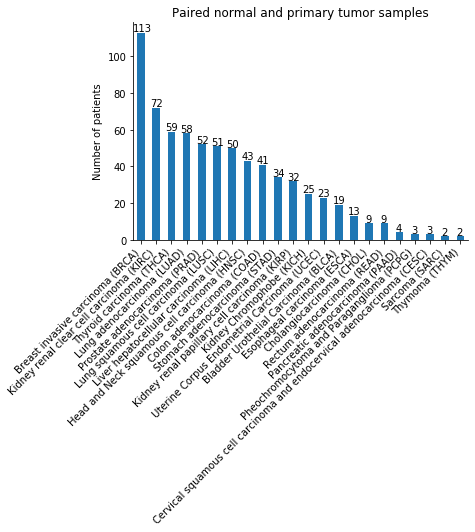

In [81]:
ax = temp.CancerType.apply(tcga_study_abbr_dict2.__getitem__).value_counts().plot(kind = 'bar', title = 'Paired normal and primary tumor samples')
for i in ax.patches:
    ax.text(i.get_x() - .15 * len(str(i.get_height())) + 0.15, i.get_height()+0.8, str(i.get_height()), fontsize=10)
#ax.invert_yaxis()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("Number of patients")

In [97]:
patient_counts = temp.CancerType.value_counts()
patient_counts

BRCA    113
KIRC     72
THCA     59
LUAD     58
PRAD     52
LUSC     51
LIHC     50
HNSC     43
COAD     41
STAD     34
KIRP     32
KICH     25
UCEC     23
BLCA     19
ESCA     13
CHOL      9
READ      9
PAAD      4
PCPG      3
CESC      3
SARC      2
THYM      2
Name: CancerType, dtype: int64

In [82]:
temp.CancerType.apply(tcga_study_abbr_dict2.__getitem__).value_counts().sum()

717

In [84]:
paired = paired[paired.PatientID.apply(temp.PatientID.tolist().__contains__)]

In [85]:
paired_mean = paired.groupby(['CancerType', 'PatientID', 'SampleType']).mean()
paired_mean

B.cells.naive  B.cells.memory  \
CancerType PatientID    SampleType                                           
BLCA       TCGA.BL.A13J Primary.Solid.Tumor       0.025527        0.039122   
                        Solid.Tissue.Normal       0.008230        0.002877   
           TCGA.BT.A20N Primary.Solid.Tumor       0.155472        0.000000   
                        Solid.Tissue.Normal       0.105722        0.018973   
           TCGA.BT.A20Q Primary.Solid.Tumor       0.045864        0.000000   
...                                                    ...             ...   
UCEC       TCGA.DI.A2QU Solid.Tissue.Normal       0.157782        0.000000   
           TCGA.DI.A2QY Primary.Solid.Tumor       0.000000        0.025093   
                        Solid.Tissue.Normal       0.000000        0.024946   
           TCGA.E6.A1M0 Primary.Solid.Tumor       0.159857        0.000000   
                        Solid.Tissue.Normal       0.266293        0.000000   

                                             Plasma.cells  T.cells.CD8  \
CancerType PatientID    SampleType                                       
BLCA       TCGA.BL.A13J Primary.Solid.Tumor      0.108216     0.028646   
                        Solid.Tissue.Normal      0.000000     0.010249   
           TCGA.BT.A20N Primary.Solid.Tumor      0.176183     0.076917   
                        Solid.Tissue.Normal      0.000000     0.019827   
           TCGA.BT.A20Q Primary.Solid.Tumor      0.129497     0.119959   
...                                                   ...          ...   
UCEC       TCGA.DI.A2QU Solid.Tissue.Normal      0.040633     0.184600   
           TCGA.DI.A2QY Primary.Solid.Tumor      0.141511     0.184388   
                        Solid.Tissue.Normal      0.009395     0.242234   
           TCGA.E6.A1M0 Primary.Solid.Tumor      0.084488     0.111003   
                        Solid.Tissue.Normal      0.231867     0.046329   

                                             T.cells.CD4.naive  \
CancerType PatientID    SampleType                               
BLCA       TCGA.BL.A13J Primary.Solid.Tumor           0.152508   
                        Solid.Tissue.Normal           0.000000   
           TCGA.BT.A20N Primary.Solid.Tumor           0.022431   
                        Solid.Tissue.Normal           0.000000   
           TCGA.BT.A20Q Primary.Solid.Tumor           0.000000   
...                                                        ...   
UCEC       TCGA.DI.A2QU Solid.Tissue.Normal           0.000000   
           TCGA.DI.A2QY Primary.Solid.Tumor           0.056263   
                        Solid.Tissue.Normal           0.000000   
           TCGA.E6.A1M0 Primary.Solid.Tumor           0.000000   
                        Solid.Tissue.Normal           0.000000   

                                             T.cells.CD4.memory.resting  \
CancerType PatientID    SampleType                                        
BLCA       TCGA.BL.A13J Primary.Solid.Tumor                    0.052339   
                        Solid.Tissue.Normal                    0.089532   
           TCGA.BT.A20N Primary.Solid.Tumor                    0.000000   
                        Solid.Tissue.Normal                    0.068638   
           TCGA.BT.A20Q Primary.Solid.Tumor                    0.110541   
...                                                                 ...   
UCEC       TCGA.DI.A2QU Solid.Tissue.Normal                    0.122660   
           TCGA.DI.A2QY Primary.Solid.Tumor                    0.000000   
                        Solid.Tissue.Normal                    0.060927   
           TCGA.E6.A1M0 Primary.Solid.Tumor                    0.000000   
                        Solid.Tissue.Normal                    0.099550   

                                             T.cells.CD4.memory.activated  \
CancerType PatientID    SampleType                                          
BLCA       TCGA.BL.A13J Primary.Solid.Tumor                      0.017278   
 

In [86]:
paired_mean['T.cells.all'] = paired_mean[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

paired_mean['B.cells.all'] = paired_mean[['B.cells.naive', 'B.cells.memory']].sum(1)

paired_mean['Nk.cells.all'] = paired_mean[['NK.cells.resting', 'NK.cells.activated']].sum(1)

paired_mean['Macrophages.all'] = paired_mean[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

paired_mean['Dendritic.cells.all'] = paired_mean[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

paired_mean['Mast.cells.all'] = paired_mean[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)

paired_mean['Leukocytes.all'] = paired_mean[cell_types].sum(1) # dummy, should all be 1.

In [87]:
paired_mean

B.cells.naive  B.cells.memory  \
CancerType PatientID    SampleType                                           
BLCA       TCGA.BL.A13J Primary.Solid.Tumor       0.025527        0.039122   
                        Solid.Tissue.Normal       0.008230        0.002877   
           TCGA.BT.A20N Primary.Solid.Tumor       0.155472        0.000000   
                        Solid.Tissue.Normal       0.105722        0.018973   
           TCGA.BT.A20Q Primary.Solid.Tumor       0.045864        0.000000   
...                                                    ...             ...   
UCEC       TCGA.DI.A2QU Solid.Tissue.Normal       0.157782        0.000000   
           TCGA.DI.A2QY Primary.Solid.Tumor       0.000000        0.025093   
                        Solid.Tissue.Normal       0.000000        0.024946   
           TCGA.E6.A1M0 Primary.Solid.Tumor       0.159857        0.000000   
                        Solid.Tissue.Normal       0.266293        0.000000   

                                             Plasma.cells  T.cells.CD8  \
CancerType PatientID    SampleType                                       
BLCA       TCGA.BL.A13J Primary.Solid.Tumor      0.108216     0.028646   
                        Solid.Tissue.Normal      0.000000     0.010249   
           TCGA.BT.A20N Primary.Solid.Tumor      0.176183     0.076917   
                        Solid.Tissue.Normal      0.000000     0.019827   
           TCGA.BT.A20Q Primary.Solid.Tumor      0.129497     0.119959   
...                                                   ...          ...   
UCEC       TCGA.DI.A2QU Solid.Tissue.Normal      0.040633     0.184600   
           TCGA.DI.A2QY Primary.Solid.Tumor      0.141511     0.184388   
                        Solid.Tissue.Normal      0.009395     0.242234   
           TCGA.E6.A1M0 Primary.Solid.Tumor      0.084488     0.111003   
                        Solid.Tissue.Normal      0.231867     0.046329   

                                             T.cells.CD4.naive  \
CancerType PatientID    SampleType                               
BLCA       TCGA.BL.A13J Primary.Solid.Tumor           0.152508   
                        Solid.Tissue.Normal           0.000000   
           TCGA.BT.A20N Primary.Solid.Tumor           0.022431   
                        Solid.Tissue.Normal           0.000000   
           TCGA.BT.A20Q Primary.Solid.Tumor           0.000000   
...                                                        ...   
UCEC       TCGA.DI.A2QU Solid.Tissue.Normal           0.000000   
           TCGA.DI.A2QY Primary.Solid.Tumor           0.056263   
                        Solid.Tissue.Normal           0.000000   
           TCGA.E6.A1M0 Primary.Solid.Tumor           0.000000   
                        Solid.Tissue.Normal           0.000000   

                                             T.cells.CD4.memory.resting  \
CancerType PatientID    SampleType                                        
BLCA       TCGA.BL.A13J Primary.Solid.Tumor                    0.052339   
                        Solid.Tissue.Normal                    0.089532   
           TCGA.BT.A20N Primary.Solid.Tumor                    0.000000   
                        Solid.Tissue.Normal                    0.068638   
           TCGA.BT.A20Q Primary.Solid.Tumor                    0.110541   
...                                                                 ...   
UCEC       TCGA.DI.A2QU Solid.Tissue.Normal                    0.122660   
           TCGA.DI.A2QY Primary.Solid.Tumor                    0.000000   
                        Solid.Tissue.Normal                    0.060927   
           TCGA.E6.A1M0 Primary.Solid.Tumor                    0.000000   
                        Solid.Tissue.Normal                    0.099550   

                                             T.cells.CD4.memory.activated  \
CancerType PatientID    SampleType                                          
BLCA       TCGA.BL.A13J Primary.Solid.Tumor                      0.017278   
 

In [88]:
paired_mean = paired_mean.reset_index()

In [89]:
paired_mean

,CancerType,PatientID,SampleType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,...,P.value,Correlation,RMSE,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all,Leukocytes.all
0,BLCA,TCGA.BL.A13J,Primary.Solid.Tumor,0.025527,0.039122,0.108216,0.028646,0.152508,0.052339,0.017278,...,0.079333,0.149832,1.025417,0.276858,0.064649,0.081032,0.341007,0.091412,0.019199,1.0
1,BLCA,TCGA.BL.A13J,Solid.Tissue.Normal,0.008230,0.002877,0.000000,0.010249,0.000000,0.089532,0.000000,...,0.010000,0.240362,0.999577,0.112962,0.011107,0.052354,0.382329,0.000000,0.358724,1.0
2,BLCA,TCGA.BT.A20N,Primary.Solid.Tumor,0.155472,0.000000,0.176183,0.076917,0.022431,0.000000,0.000000,...,0.000000,0.392916,0.923030,0.194265,0.155472,0.003256,0.320324,0.068766,0.058944,1.0
3,BLCA,TCGA.BT.A20N,Solid.Tissue.Normal,0.105722,0.018973,0.000000,0.019827,0.000000,0.068638,0.000000,...,0.030000,0.191548,1.007749,0.129438,0.124695,0.019699,0.412744,0.009391,0.152084,1.0
4,BLCA,TCGA.BT.A20Q,Primary.Solid.Tumor,0.045864,0.000000,0.129497,0.119959,0.000000,0.110541,0.023016,...,0.008000,0.250971,0.984202,0.416828,0.045864,0.011285,0.321904,0.043068,0.008741,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,UCEC,TCGA.DI.A2QU,Solid.Tissue.Normal,0.157782,0.000000,0.040633,0.184600,0.000000,0.122660,0.000000,...,0.054000,0.142075,1.031057,0.385024,0.157782,0.051667,0.259308,0.004352,0.067701,1.0
1430,UCEC,TCGA.DI.A2QY,Primary.Solid.Tumor,0.000000,0.025093,0.141511,0.184388,0.056263,0.000000,0.000000,...,0.034000,0.206250,1.009540,0.489109,0.025093,0.000000,0.196466,0.000000,0.131834,1.0
1431,UCEC,TCGA.DI.A2QY,Solid.Tissue.Normal,0.000000,0.024946,0.009395,0.242234,0.000000,0.060927,0.000000,...,0.262000,0.043406,1.080582,0.493860,0.024946,0.080841,0.236380,0.000000,0.090559,1.0
1432,UCEC,TCGA.E6.A1M0,Primary.Solid.Tumor,0.159857,0.000000,0.084488,0.111003,0.000000,0.000000,0.000004,...,0.014000,0.306328,0.962843,0.341854,0.159857,0.080596,0.307251,0.000491,0.025463,1.0


In [90]:
cancer_types = paired_mean.CancerType.unique()

## Correlation

In [98]:
f = lambda x, j: corr(x[x.SampleType == 'Primary.Solid.Tumor'][j], x[x.SampleType == 'Solid.Tissue.Normal'][j])
paired_corr = pd.DataFrame({i: {j: f(paired_mean[paired_mean.CancerType == i], j) for j in augmented_cell_types} for i in cancer_types})

paired_corr[patient_counts.index.tolist()].style.apply(lambda x: ["color: red" if v > 0.2 else "color: blue" if v < -0.2 else "color: grey" if np.isnan(v) else "" for v in x], axis = 1)

/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,BRCA,KIRC,THCA,LUAD,PRAD,LUSC,LIHC,HNSC,COAD,STAD,KIRP,KICH,UCEC,BLCA,ESCA,CHOL,READ,PAAD,PCPG,CESC,SARC,THYM
B.cells.naive,0.335705,0.270752,0.424023,0.475894,0.251127,0.113961,-0.018670,0.103936,-0.019025,0.015289,0.182802,0.178432,0.091581,0.167204,0.187694,0.223172,0.016116,0.080583,-0.517289,-0.526565,-1.000000,nan
B.cells.memory,0.049975,0.150398,0.197809,-0.065622,0.024967,-0.042135,-0.107859,0.062362,-0.079223,-0.253838,0.361319,-0.218273,-0.082492,0.325629,0.776672,-0.015473,-0.065909,-0.028731,0.695856,nan,nan,-1.000000
Plasma.cells,0.108794,0.064812,0.195367,0.312239,0.184174,0.327953,0.126047,0.002154,0.037638,0.097221,0.051053,0.159008,0.129735,-0.099803,0.159410,-0.122469,-0.022572,0.294727,0.421763,-0.251253,-1.000000,-1.000000
T.cells.CD8,0.280467,-0.026212,-0.189805,0.193767,0.309294,0.053312,0.021696,0.001129,0.404048,0.277131,-0.044735,-0.207165,0.263120,0.493290,0.310241,-0.057436,-0.442134,0.342904,-0.281275,0.917529,-1.000000,1.000000
T.cells.CD4.naive,nan,nan,-0.025627,nan,nan,-0.033259,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000
T.cells.CD4.memory.resting,0.192681,0.218822,0.378611,0.273195,0.326105,-0.012771,0.306619,0.167177,0.183860,0.399844,-0.026751,0.024804,0.305834,0.476298,0.576347,-0.406114,-0.004678,-0.026473,-0.240013,0.783099,1.000000,nan
T.cells.CD4.memory.activated,0.008678,-0.024331,-0.032163,0.538777,nan,0.013358,0.031265,-0.092630,-0.101773,-0.065375,nan,nan,nan,0.733004,-0.198278,nan,nan,nan,nan,nan,nan,-1.000000
T.cells.follicular.helper,0.259855,0.208405,0.386401,0.117424,0.223766,0.094699,0.027962,-0.015315,0.235854,0.209784,0.594803,-0.036330,0.103530,0.061697,0.351013,0.415264,0.062844,0.870471,0.999487,-0.796715,1.000000,1.000000
T.cells.regulatory..Tregs.,0.068006,0.186400,0.141562,-0.037353,0.373800,0.129449,0.189308,0.427982,0.298618,0.134087,0.262508,0.168191,0.063575,0.317205,0.634402,-0.211093,-0.070629,0.549209,nan,-0.824867,-1.000000,-1.000000
T.cells.gamma.delta,0.009871,0.068901,-0.043286,nan,nan,nan,-0.018865,-0.035755,-0.031656,nan,nan,-0.079916,-0.076575,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [99]:
paired_corr_valid = paired_corr.drop(['PCPG', 'CESC', 'THYM', 'SARC'], axis = 1)
(paired_corr_valid > 0).apply(np.count_nonzero).sum()  / paired_corr_valid.size

0.6091954022988506

## 95% Confidence Interval
Entry which is entierly greater than 0.0 is colored in red.

In [100]:
paired_corr_ci = pd.DataFrame({i: {j: [round(x, 2) for x in corr_ci(paired_corr.loc[j, i], patient_counts[i], 0.05)] for j in augmented_cell_types} for i in cancer_types})
paired_corr_ci[patient_counts.index.tolist()].style.apply(lambda x: ["color: red" if v[0] > 0.0 else "color: blue" if v[1] < 0.0 else "" for v in x], axis = 1)

<ipython-input-47-165a4dd84b1c>:19: RuntimeWarning: divide by zero encountered in double_scalars
  se = 1 / np.sqrt(n - 3)
<ipython-input-47-165a4dd84b1c>:18: RuntimeWarning: divide by zero encountered in double_scalars
  z_r = np.log((1 + r) / (1 - r)) / 2
<ipython-input-47-165a4dd84b1c>:21: RuntimeWarning: invalid value encountered in double_scalars
  return list(map(np.tanh, [z_r - z_critical * se, z_r + z_critical * se]))


,BRCA,KIRC,THCA,LUAD,PRAD,LUSC,LIHC,HNSC,COAD,STAD,KIRP,KICH,UCEC,BLCA,ESCA,CHOL,READ,PAAD,PCPG,CESC,SARC,THYM
B.cells.naive,"[0.16, 0.49]","[0.04, 0.47]","[0.19, 0.61]","[0.25, 0.65]","[-0.02, 0.49]","[-0.17, 0.38]","[-0.3, 0.26]","[-0.2, 0.39]","[-0.32, 0.29]","[-0.32, 0.35]","[-0.18, 0.5]","[-0.23, 0.54]","[-0.33, 0.49]","[-0.31, 0.58]","[-0.41, 0.67]","[-0.52, 0.77]","[-0.66, 0.67]","[-0.95, 0.97]","[-1.0, 1.0]","[-1.0, 1.0]","[-1, 1]","[-1, 1]"
B.cells.memory,"[-0.14, 0.23]","[-0.08, 0.37]","[-0.06, 0.43]","[-0.32, 0.2]","[-0.25, 0.3]","[-0.31, 0.24]","[-0.37, 0.18]","[-0.24, 0.36]","[-0.38, 0.23]","[-0.55, 0.09]","[0.01, 0.63]","[-0.56, 0.19]","[-0.48, 0.34]","[-0.15, 0.68]","[0.39, 0.93]","[-0.67, 0.66]","[-0.7, 0.63]","[-0.96, 0.96]","[-1.0, 1.0]","[nan, nan]","[-1, 1]","[-1, 1]"
Plasma.cells,"[-0.08, 0.29]","[-0.17, 0.29]","[-0.06, 0.43]","[0.06, 0.53]","[-0.09, 0.44]","[0.06, 0.55]","[-0.16, 0.39]","[-0.3, 0.3]","[-0.27, 0.34]","[-0.25, 0.42]","[-0.3, 0.39]","[-0.25, 0.52]","[-0.3, 0.51]","[-0.53, 0.37]","[-0.43, 0.65]","[-0.73, 0.59]","[-0.68, 0.65]","[-0.93, 0.98]","[-1.0, 1.0]","[-1.0, 1.0]","[-1, 1]","[-1, 1]"
T.cells.CD8,"[0.1, 0.44]","[-0.26, 0.21]","[-0.43, 0.07]","[-0.07, 0.43]","[0.04, 0.54]","[-0.23, 0.32]","[-0.26, 0.3]","[-0.3, 0.3]","[0.11, 0.63]","[-0.07, 0.56]","[-0.39, 0.31]","[-0.56, 0.2]","[-0.17, 0.61]","[0.05, 0.77]","[-0.29, 0.74]","[-0.7, 0.63]","[-0.86, 0.31]","[-0.92, 0.98]","[-1.0, 1.0]","[-1.0, 1.0]","[-1, 1]","[-1, 1]"
T.cells.CD4.naive,"[nan, nan]","[nan, nan]","[-0.28, 0.23]","[nan, nan]","[nan, nan]","[-0.31, 0.24]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[-1, 1]","[-1, 1]"
T.cells.CD4.memory.resting,"[0.01, 0.36]","[-0.01, 0.43]","[0.14, 0.58]","[0.02, 0.5]","[0.06, 0.55]","[-0.29, 0.26]","[0.03, 0.54]","[-0.14, 0.45]","[-0.13, 0.47]","[0.07, 0.65]","[-0.37, 0.32]","[-0.37, 0.42]","[-0.12, 0.64]","[0.03, 0.77]","[0.04, 0.86]","[-0.84, 0.35]","[-0.67, 0.66]","[-0.96, 0.96]","[-1.0, 1.0]","[-1.0, 1.0]","[-1, 1]","[-1, 1]"
T.cells.CD4.memory.activated,"[-0.18, 0.19]","[-0.25, 0.21]","[-0.29, 0.23]","[0.33, 0.7]","[nan, nan]","[-0.26, 0.29]","[-0.25, 0.31]","[-0.38, 0.21]","[-0.4, 0.21]","[-0.39, 0.28]","[nan, nan]","[nan, nan]","[nan, nan]","[0.42, 0.89]","[-0.68, 0.4]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[-1, 1]","[-1, 1]"
T.cells.follicular.helper,"[0.08, 0.42]","[-0.02, 0.42]","[0.14, 0.58]","[-0.15, 0.36]","[-0.05, 0.47]","[-0.19, 0.36]","[-0.25, 0.3]","[-0.31, 0.29]","[-0.08, 0.51]","[-0.14, 0.51]","[0.31, 0.78]","[-0.43, 0.36]","[-0.32, 0.49]","[-0.4, 0.5]","[-0.25, 0.76]","[-0.34, 0.85]","[-0.63, 0.7]","[-0.55, 1.0]","[-1.0, 1.0]","[-1.0, 1.0]","[-1, 1]","[-1, 1]"
T.cells.regulatory..Tregs.,"[-0.12, 0.25]","[-0.05, 0.4]","[-0.12, 0.38]","[-0.29, 0.22]","[0.11, 0.59]","[-0.15, 0.39]","[-0.09, 0.44]","[0.15, 0.65]","[-0.01, 0.56]","[-0.21, 0.45]","[-0.09, 0.56]","[-0.24, 0.53]","[-0.36, 0.46]","[-0.16, 0.67]","[0.13, 0.88]","[-0.77, 0.53]","[-0.7, 0.62]","[-0.87, 0.99]","[nan, nan]","[-1.0, 1.0]","[-1, 1]","[-1, 1]"
T.cells.gamma.delta,"[-0.18, 0.19]","[-0.17, 0.3]","[-0.3, 0.22]","[nan, nan]","[nan, nan]","[nan, nan]","[-0.3, 0.26]","[-0.33, 0.27]","[-0.34, 0.28]","[nan, nan]","[nan, nan]","[-0.46, 0.33]","[-0.47, 0.35]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[-1, 1]","[-1, 1]"


[Text(0, 0, 'Breast invasive carcinoma (BRCA)'),
 Text(0, 0, 'Kidney renal clear cell carcinoma (KIRC)'),
 Text(0, 0, 'Thyroid carcinoma (THCA)'),
 Text(0, 0, 'Lung adenocarcinoma (LUAD)'),
 Text(0, 0, 'Prostate adenocarcinoma (PRAD)'),
 Text(0, 0, 'Lung squamous cell carcinoma (LUSC)'),
 Text(0, 0, 'Liver hepatocellular carcinoma (LIHC)'),
 Text(0, 0, 'Head and Neck squamous cell carcinoma (HNSC)'),
 Text(0, 0, 'Colon adenocarcinoma (COAD)'),
 Text(0, 0, 'Stomach adenocarcinoma (STAD)'),
 Text(0, 0, 'Kidney renal papillary cell carcinoma (KIRP)'),
 Text(0, 0, 'Kidney Chromophobe (KICH)'),
 Text(0, 0, 'Uterine Corpus Endometrial Carcinoma (UCEC)'),
 Text(0, 0, 'Bladder Urothelial Carcinoma (BLCA)'),
 Text(0, 0, 'Esophageal carcinoma (ESCA)'),
 Text(0, 0, 'Cholangiocarcinoma (CHOL)'),
 Text(0, 0, 'Rectum adenocarcinoma (READ)'),
 Text(0, 0, 'Pancreatic adenocarcinoma (PAAD)'),
 Text(0, 0, 'Pheochromocytoma and Paraganglioma (PCPG)'),
 Text(0, 0, 'Cervical squamous cell carcinoma and end

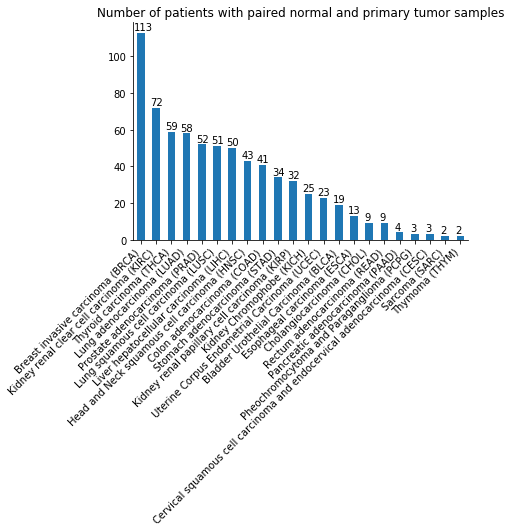

In [101]:
ax = temp.CancerType.apply(tcga_study_abbr_dict2.__getitem__).value_counts().plot(kind = 'bar', title = 'Number of patients with paired normal and primary tumor samples')
for i in ax.patches:
    ax.text(i.get_x() - .07 * len(str(i.get_height())), i.get_height()+1.5, str(i.get_height()), fontsize=10)
#ax.invert_yaxis()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [102]:
patient_counts

BRCA    113
KIRC     72
THCA     59
LUAD     58
PRAD     52
LUSC     51
LIHC     50
HNSC     43
COAD     41
STAD     34
KIRP     32
KICH     25
UCEC     23
BLCA     19
ESCA     13
CHOL      9
READ      9
PAAD      4
PCPG      3
CESC      3
SARC      2
THYM      2
Name: CancerType, dtype: int64

In [103]:
patient_counts.sum()

717

In [104]:
paired_corr[patient_counts.index.tolist()].to_csv("normal_primary.csv")
paired_corr_lower = pd.DataFrame({i: {j: corr_ci(paired_corr.loc[j, i], patient_counts[i], 0.05, 'lower') for j in augmented_cell_types} for i in cancer_types})
paired_corr_upper = pd.DataFrame({i: {j: corr_ci(paired_corr.loc[j, i], patient_counts[i], 0.05, 'upper') for j in augmented_cell_types} for i in cancer_types})
paired_corr_lower[patient_counts.index.tolist()].to_csv("normal_primary_lower.csv")
paired_corr_upper[patient_counts.index.tolist()].to_csv("normal_primary_upper.csv")

<ipython-input-47-165a4dd84b1c>:19: RuntimeWarning: divide by zero encountered in double_scalars
  se = 1 / np.sqrt(n - 3)
<ipython-input-47-165a4dd84b1c>:18: RuntimeWarning: divide by zero encountered in double_scalars
  z_r = np.log((1 + r) / (1 - r)) / 2
<ipython-input-47-165a4dd84b1c>:23: RuntimeWarning: invalid value encountered in double_scalars
  return np.tanh(z_r - z_critical * se)


In [105]:
f = lambda x, j: scipy.stats.pearsonr(x[x.SampleType == 'Primary.Solid.Tumor'][j], x[x.SampleType == 'Solid.Tissue.Normal'][j])[1]
paired_corr_p = pd.DataFrame({i: {j: f(paired_mean[paired_mean.CancerType == i], j) for j in augmented_cell_types} for i in cancer_types})
paired_corr_p[patient_counts.index.tolist()].style.apply(lambda x: ["color: red" if v < 0.05 else "" for v in x], axis = 1)

/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


,BRCA,KIRC,THCA,LUAD,PRAD,LUSC,LIHC,HNSC,COAD,STAD,KIRP,KICH,UCEC,BLCA,ESCA,CHOL,READ,PAAD,PCPG,CESC,SARC,THYM
B.cells.naive,0.000278,0.021428,0.000818,0.000160,0.072529,0.425877,0.897601,0.507158,0.906020,0.931611,0.316628,0.393457,0.677712,0.493858,0.539184,0.563808,0.967176,0.919417,0.653882,0.646959,1.000000,nan
B.cells.memory,0.599122,0.207302,0.133155,0.624552,0.860536,0.769083,0.455929,0.691167,0.622464,0.147449,0.042171,0.294548,0.708259,0.173689,0.001791,0.968485,0.866215,0.971269,0.510051,nan,nan,1.000000
Plasma.cells,0.251361,0.588583,0.138110,0.017025,0.191203,0.018805,0.383084,0.989062,0.815274,0.584387,0.781403,0.447741,0.555195,0.684365,0.602928,0.753605,0.954036,0.705273,0.722823,0.838315,1.000000,1.000000
T.cells.CD8,0.002622,0.826991,0.149909,0.145002,0.025671,0.710226,0.881117,0.994269,0.008795,0.112569,0.807918,0.320404,0.225120,0.031858,0.302250,0.883313,0.233418,0.657096,0.818485,0.260361,1.000000,1.000000
T.cells.CD4.naive,nan,nan,0.847224,nan,nan,0.816779,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000
T.cells.CD4.memory.resting,0.040889,0.064788,0.003108,0.037991,0.018309,0.929123,0.030330,0.283939,0.249851,0.019132,0.884449,0.906315,0.155839,0.039249,0.039234,0.278109,0.990471,0.973527,0.845697,0.427276,1.000000,nan
T.cells.CD4.memory.activated,0.927316,0.839236,0.808914,0.000013,nan,0.925875,0.829346,0.554660,0.526630,0.713372,nan,nan,nan,0.000357,0.516103,nan,nan,nan,nan,nan,nan,1.000000
T.cells.follicular.helper,0.005444,0.078956,0.002504,0.380027,0.110787,0.508608,0.847147,0.922348,0.137667,0.233735,0.000330,0.863117,0.638289,0.801882,0.239609,0.266363,0.872397,0.129529,0.020393,0.413138,1.000000,1.000000
T.cells.regulatory..Tregs.,0.474177,0.116939,0.284849,0.780725,0.006339,0.365278,0.187942,0.004197,0.057896,0.449628,0.146645,0.421599,0.773208,0.185742,0.019862,0.585615,0.856712,0.450791,nan,0.382500,1.000000,1.000000
T.cells.gamma.delta,0.917358,0.565227,0.744786,nan,nan,nan,0.896542,0.819936,0.844234,nan,nan,0.704146,0.728389,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [106]:
paired_corr_p[patient_counts.index.tolist()].to_csv("normal_primary_p.csv")

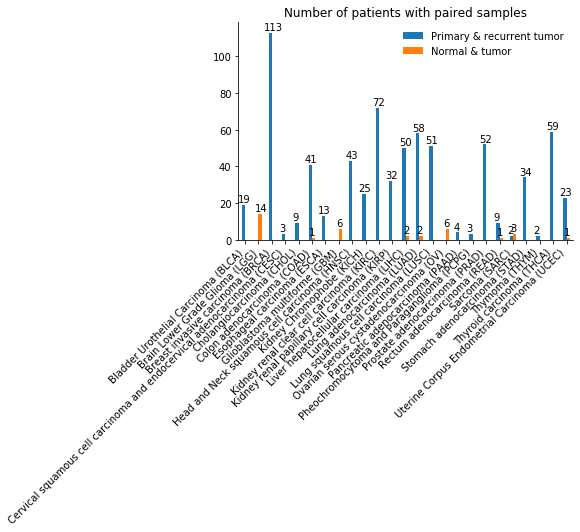

In [107]:
ax = pd.DataFrame({'Primary & recurrent tumor': temp.CancerType.apply(tcga_study_abbr_dict2.__getitem__).value_counts(), 
              'Normal & tumor': temp0.CancerType.apply(tcga_study_abbr_dict2.__getitem__).value_counts()}).plot(kind = 'bar', title = 'Number of patients with paired samples')

for i in ax.patches:
    if i.get_height() >= 1:
        ax.text(i.get_x() - .07 * len(str(i.get_height())), i.get_height()+1.5, str(int(round(i.get_height()))), fontsize=10)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(frameon=False)

# Part 3: Basic statistics

In [108]:
f = lambda x: tcga_sample_type_dict[x.split('-')[3][0:2]]
all_data = data.copy()
all_data["SampleType"] = all_data["SampleID"].apply(f)
all_data.groupby(["CancerType", "SampleType"]).SampleID.count().to_frame()

SampleID
CancerType SampleType                     
ACC        Primary Solid Tumor          79
BLCA       Primary Solid Tumor         414
           Solid Tissue Normal          19
BRCA       Metastatic                    7
           Primary Solid Tumor        1135
...                                    ...
UCEC       Primary Solid Tumor         557
           Recurrent Solid Tumor         1
           Solid Tissue Normal          35
UCS        Primary Solid Tumor          57
UVM        Primary Solid Tumor          80

[82 rows x 1 columns]

In [109]:
all_data.SampleType.unique().tolist()

['Primary Solid Tumor',
 'Solid Tissue Normal',
 'Metastatic',
 'Recurrent Solid Tumor',
 'Additional - New Primary',
 'Primary Blood Derived Cancer - Peripheral Blood',
 'Additional Metastatic']

In [110]:
sample_size = pd.crosstab(all_data["CancerType"], all_data["SampleType"])
sample_size.T.style

CancerType,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,KICH,KIRC,KIRP,LAML,LGG,LIHC,LUAD,LUSC,MESO,OV,PAAD,PCPG,PRAD,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
SampleType,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Additional - New Primary,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,6,0,0,0,0,0
Additional Metastatic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Metastatic,0,0,7,2,0,1,0,1,0,2,0,0,0,0,0,0,0,0,0,0,1,2,1,0,1,368,0,0,8,0,0,0,0
Primary Blood Derived Cancer - Peripheral Blood,0,0,0,0,0,0,0,0,0,0,0,0,0,179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Primary Solid Tumor,79,414,1135,304,36,503,48,184,157,520,66,545,290,0,516,371,540,504,87,423,178,179,505,166,259,103,416,150,505,120,557,57,80
Recurrent Solid Tumor,0,0,0,0,0,1,0,0,13,0,0,0,0,0,18,3,2,0,0,7,0,0,0,1,3,0,0,0,0,0,1,0,0
Solid Tissue Normal,0,19,114,3,9,41,0,13,5,44,25,72,32,0,0,50,59,51,0,0,4,3,52,10,2,1,37,0,59,2,35,0,0


In [111]:
all_data['T.cells.all'] = all_data[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

all_data['B.cells.all'] = all_data[['B.cells.naive', 'B.cells.memory']].sum(1)

all_data['Nk.cells.all'] = all_data[['NK.cells.resting', 'NK.cells.activated']].sum(1)

all_data['Macrophages.all'] = all_data[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

all_data['Dendritic.cells.all'] = all_data[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

all_data['Mast.cells.all'] = all_data[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)

all_data['Leukocytes.all'] = all_data[cell_types].sum(1)

augmented_cell_types = cell_types + ['T.cells.all', 'B.cells.all', 'Nk.cells.all', 'Macrophages.all', 
                                     'Dendritic.cells.all', 'Mast.cells.all', 'Leukocytes.all']

## Commons

In [140]:
a = 0.05


for sample_type in sample_size.columns:
    sample_type_mean = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_mean_lower = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_mean_upper = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd_lower = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd_upper = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)

    for j in sample_type_mean.columns:
        n = ((all_data.CancerType == j) & (all_data.SampleType == sample_type)).sum()

        # Mean
        sample_type_mean.loc[:, j] = all_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].mean(axis=0)

        # Standard deviation
        sample_type_sd.loc[:, j] = all_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].std(ddof=1, axis=0)

        # Mean CI
        err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sample_type_sd.loc[:, j] / np.sqrt(n)
        sample_type_mean_lower.loc[:, j] = sample_type_mean.loc[:, j] - err
        sample_type_mean_upper.loc[:, j] = sample_type_mean.loc[:, j] + err

        # Standard deviation CI
        sample_type_sd_lower.loc[:, j] = np.sqrt((n - 1) * sample_type_sd.loc[:, j] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
        sample_type_sd_upper.loc[:, j] = np.sqrt((n - 1) * sample_type_sd.loc[:, j] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

    index_str_len = sample_type_mean.index.to_series().apply(lambda x: len(x)).max()
    index_str_len
        
    with pd.ExcelWriter(sample_type + ".xlsx", engine="xlsxwriter") as writer:
        sample_type_mean.to_excel(writer, sheet_name="mean")
        sample_type_mean_lower.to_excel(writer, sheet_name="mean 95% CI lower")
        sample_type_mean_upper.to_excel(writer, sheet_name="mean 95% CI upper")
        (sample_type_mean_upper - sample_type_mean_lower).to_excel(writer, sheet_name="mean 95% CI size")
        
        sample_type_sd.to_excel(writer, sheet_name="sd")
        sample_type_sd_lower.to_excel(writer, sheet_name="sd 95% CI lower")
        sample_type_sd_upper.to_excel(writer, sheet_name="sd 95% CI upper")
        (sample_type_sd_upper - sample_type_sd_lower).to_excel(writer, sheet_name="sd 95% CI size")
        for i in writer.sheets:
            writer.sheets[i].set_column('A:A', index_str_len)

Index(['Additional - New Primary', 'Additional Metastatic', 'Metastatic',
       'Primary Blood Derived Cancer - Peripheral Blood',
       'Primary Solid Tumor', 'Recurrent Solid Tumor', 'Solid Tissue Normal'],
      dtype='object', name='SampleType')